In [1]:
import os
from functools import wraps
from collections import defaultdict
from tqdm import tqdm

from logdeep.models.lstm import deeplog, loganomaly, robustlog
from logdeep.tools.predict import Predicter
from logdeep.tools.train import Trainer
from logdeep.tools.utils import *
from logdeep.dataset.mylog import log_dataset
# from logdeep.dataset.log import log_dataset
from logdeep.dataset.sample import sliding_window, session_window
from logdeep.tools.utils import (save_parameters, seed_everything,
                                 train_val_split)

import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
import copy
import random
import time
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from argparse import ArgumentParser
from torchvision import transforms as tt
from PIL import Image
from utils import AverageMeter

In [2]:
# set manual seed for reproducibility
seed = 1234

In [3]:
# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Hyperparameters_List (H) = [rounds, client_fraction, number_of_clients, number_of_training_rounds_local, local_batch_size, lr_client]

stop_gradient = True
has_predictor = True
OneLayer = "1_layer"
TwoLayer = "2_layer"
predictor_network=TwoLayer
global_epochs = 1000
client_fraction = 1.0
client_num = 5
local_epoch = 5
batch_size = 512
lr = 3e-4
partition = 'iid'
norm = 'bn'
alpha_partition = 0.5
sch_flag = False
iid = False
avg_freq = 1

data_portion = 1.0
noniid_ratio = 1.0
# noniid_ratio = 0.55

# save_path = f"./model/SplitFSSL_resnet18/resnet18_cifar10_noniid_{batch_size}_{noniid_ratio}_{client_num}"
save_path = f"./model/SplitFSSLMaxpool_deeplog/SplitFSSLdeeplog_log_{batch_size}_{noniid_ratio}_{client_num}"
H = [global_epochs, client_fraction, client_num, local_epoch, batch_size, lr]

In [6]:
logoptions = dict()
logoptions['data_dir'] = './data/'
logoptions['window_size'] = 10
# logoptions['device'] = "cpu"

# Smaple
logoptions['sample'] = "sliding_window"
logoptions['window_size'] = 10  # if fix_window

# Features
logoptions['sequentials'] = True
logoptions['quantitatives'] = False
logoptions['semantics'] = False
logoptions['feature_num'] = sum(
    [logoptions['sequentials'], logoptions['quantitatives'], logoptions['semantics']])

In [7]:
def save_checkpoint(state, checkpoint, filename= 'checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    os.makedirs(checkpoint, exist_ok=True)
    torch.save(state, filepath)
    print(f'global epoch {state["glepoch"]} saved')

In [8]:
if logoptions['sample'] == 'sliding_window':
    train_logs, train_labels = sliding_window(logoptions['data_dir'],
                                              datatype='train',
                                              window_size=logoptions['window_size'],
                                              clientnum = client_num)
    # val_logs, val_labels = sliding_window(logoptions['data_dir'],
    #                                       datatype='val',
    #                                       window_size=logoptions['window_size'],
    #                                       clientnum = client_num,
    #                                       sample_ratio=0.001)
elif logoptions['sample'] == 'session_window':
    train_logs, train_labels = session_window(logoptions['data_dir'],
                                              datatype='train')
    # val_logs, val_labels = session_window(logoptions['data_dir'],
    #                                       datatype='val')
else:
    raise NotImplementedError


File ./data/hdfs/hdfs_train, number of sessions 4855
number of client 0 seqs 9548
number of client 1 seqs 9273
number of client 2 seqs 9301
number of client 3 seqs 9272
number of client 4 seqs 9181


In [9]:
train_dataset = []
# valid_dataset = []
for trainlog, label in zip(train_logs, train_labels):
    dataset = log_dataset(logs=trainlog,
                                labels=label,
                                seq=logoptions['sequentials'],
                                quan=logoptions['quantitatives'],
                                sem=logoptions['semantics'])
    train_dataset.append(dataset)
    
# for vallog, label in zip(val_logs, val_labels):  
#     dataset = log_dataset(logs=vallog,
#                                 labels=label,
#                                 seq=logoptions['sequentials'],
#                                 quan=logoptions['quantitatives'],
#                                 sem=logoptions['semantics'])
#     valid_dataset.append(dataset)

In [10]:
train_loader = []
# valid_loader = []
for dataset in train_dataset:
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True,
                        drop_last=True)
    train_loader.append(loader)
# for dataset in valid_dataset:
#     loader = DataLoader(dataset,
#                         batch_size=batch_size,
#                         shuffle=False,
#                         pin_memory=True)
#     valid_loader.append(loader)

In [11]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

In [12]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

In [13]:
def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(
            current_model.parameters(), ma_model.parameters()
    ):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)


def byol_loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

In [14]:
class MLP(nn.Module):
    def __init__(self, dim, projection_size, hidden_size=4096, num_layer=TwoLayer):
        super().__init__()
        self.in_features = dim
        if num_layer == OneLayer:
            self.net = nn.Sequential(
                nn.Linear(dim, projection_size),
            )
        elif num_layer == TwoLayer:
            self.net = nn.Sequential(
                nn.Linear(dim, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_size, projection_size),
            )
        else:
            raise NotImplementedError(f"Not defined MLP: {num_layer}")

    def forward(self, x):
        return self.net(x)

In [15]:
#client model
class BYOL_Client(nn.Module):
    def __init__(
        self,
        net,
        image_size=32,
        projection_size=2048,
        projection_hidden_size=4096,
        moving_average_decay=0.99,
        stop_gradient=True,
        has_predictor=True,
        predictor_network=TwoLayer,
    ):
        super().__init__()

        self.online_encoder = net
        if not hasattr(net, 'feature_dim'):
            feature_dim = list(net.children())[-1].in_features
        else:
            feature_dim = net.feature_dim
        self.online_encoder.fc = MLP(feature_dim, projection_size, projection_hidden_size)  # projector

        self.target_encoder = None
        self.target_ema_updater = EMA(moving_average_decay)

        self.stop_gradient = stop_gradient
        self.has_predictor = has_predictor
        
        # debug purpose
        # self.forward(torch.randn(2, 3, image_size, image_size), torch.randn(2, 3, image_size, image_size))
        # self.reset_moving_average()
        
    def _get_target_encoder(self):
        target_encoder = copy.deepcopy(self.online_encoder)
        return target_encoder

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_moving_average(self):
        assert (
                self.target_encoder is not None
        ), "target encoder has not been created yet"
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, image_one, image_two):
        online_proj_one = self.online_encoder(image_one)
        online_proj_two = self.online_encoder(image_two)

        # online_pred_one = self.online_predictor(online_proj_one)
        # online_pred_two = self.online_predictor(online_proj_two)

        if self.stop_gradient:
            with torch.no_grad():
                if self.target_encoder is None:
                    self.target_encoder = self._get_target_encoder()
                target_proj_one = self.target_encoder(image_one)
                target_proj_two = self.target_encoder(image_two)

                target_proj_one = target_proj_one.detach()
                target_proj_two = target_proj_two.detach()


        # loss_one = loss_fn(online_pred_one, target_proj_two.detach())
        # loss_two = loss_fn(online_pred_two, target_proj_one.detach())

        # loss = loss_one + loss_two
        return online_proj_one, online_proj_two, target_proj_one, target_proj_two

In [16]:
# server model
class BYOL_Server(nn.Module):
    def __init__(
        self,
        projection_size=2048,
        projection_hidden_size=4096,
        moving_average_decay=0.99,
        predictor_network=TwoLayer,
    ):
        super().__init__()

        self.online_predictor = MLP(projection_size, projection_size, projection_hidden_size, predictor_network)

    def forward(self, online_proj_one, online_proj_two, target_proj_one, target_proj_two):

        online_pred_one = self.online_predictor(online_proj_one)
        online_pred_two = self.online_predictor(online_proj_two)


        loss_one = byol_loss_fn(online_pred_one, target_proj_two)
        loss_two = byol_loss_fn(online_pred_two, target_proj_one)
        loss = loss_one + loss_two
        
        return loss.mean()

In [17]:
# net = ResNet18()
net = deeplog(input_size=1, hidden_size=64, num_layers=2, num_keys=28)
client_model = BYOL_Client(net=net, projection_size=28, projection_hidden_size=64, 
                           stop_gradient=stop_gradient, has_predictor=has_predictor, predictor_network=predictor_network)
server_model = BYOL_Server(projection_size=28, projection_hidden_size=64)
server_model.cuda()

client_weights = [1/5 for i in range(client_num)]
client_models = [copy.deepcopy(client_model).cuda() for idx in range(client_num)]
# server_models = [copy.deepcopy(server_model).cuda() for idx in range(client_num)]

optimizer_server = torch.optim.Adam(server_model.parameters(), lr = H[5]) 
optimizer_clients = [torch.optim.Adam(client_models[i].parameters(), lr = H[5]) for i in range(len(client_models))]

In [18]:
# if using checkpoint to train
epoch = 0
# checkpath = save_path + "/checkpoint.pth.tar" 
# checkpoint = torch.load(checkpath)
# epoch = checkpoint['glepoch']
# print(epoch)
# optimizer_server.load_state_dict(checkpoint['optimizer'][0])
# for localmodel in client_models:
#     localmodel.online_encoder.load_state_dict(checkpoint['state_dict'])
# for clientidx in range(client_num):
#     optimizer_clients[clientidx].load_state_dict(checkpoint['optimizer'][clientidx+1])

In [19]:
client_model

BYOL_Client(
  (online_encoder): deeplog(
    (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
    (fc): MLP(
      (net): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=64, out_features=28, bias=True)
      )
    )
  )
)

In [20]:
server_model

BYOL_Server(
  (online_predictor): MLP(
    (net): Sequential(
      (0): Linear(in_features=28, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=64, out_features=28, bias=True)
    )
  )
)

In [21]:
class create_iterator():
    def __init__(self, iterator) -> None:
        self.iterator = iterator

    def __next__(self):
        return next(self.iterator)

In [22]:
client_iterator_list = []

for client_id in range(client_num):
    client_iterator_list.append(create_iterator(iter((train_loader[client_id]))))

In [23]:
# read one batch of image pair
def next_data_batch(client_id):
    try:
        log1, log2, log = next(client_iterator_list[client_id])
        
        if log1.size(0) != batch_size:
            try:
                next(client_iterator_list[client_id])
            except StopIteration:
                pass
            client_iterator_list[client_id] = create_iterator(iter((train_loader[client_id])))
            log1, log2, log = next(client_iterator_list[client_id])
    except StopIteration:
        client_iterator_list[client_id] = create_iterator(iter((train_loader[client_id])))
        log1, log2, log = next(client_iterator_list[client_id])
    return log1, log2, log

In [24]:
def train_server(online_proj_one, online_proj_two, target_proj_one, target_proj_two, server_model):
    
    # print("shape", online_proj_one.shape)
    # print("online_proj_one", online_proj_one)
    
    
    online_proj_one.requires_grad = True
    online_proj_two.requires_grad = True
    
    online_proj_one.retain_grad()
    online_proj_two.retain_grad()

    server_model.train()
    
    # forward prop
    loss = server_model(online_proj_one, online_proj_two, target_proj_one, target_proj_two)
    
    if online_proj_one.grad is not None:
        online_proj_one.grad.zero_()
        
    if online_proj_two.grad is not None:
        online_proj_two.grad.zero_()
            
    # backward prop
    loss.backward()
    online_proj_one_grad, online_proj_two_grad = online_proj_one.grad.detach().clone(), online_proj_two.grad.detach().clone()
    # print("online_proj_one_grad", online_proj_one_grad.shape)
    # print("online_proj_two_grad", online_proj_two_grad.shape)
    
    return online_proj_one_grad, online_proj_two_grad, loss

In [25]:
def optimizer_zero_grads(optimizer_server, optimizer_clients):  # This needs to be called
    optimizer_server.zero_grad()
    for i in range(client_num):
        optimizer_clients[i].zero_grad()

In [26]:
def training(client_models, server_model, optimizer_server, optimizer_clients, rounds, batch_size, lr, C, K, local_epochs, plt_title, plt_color, cifar_data_test=None,
             test_batch_size=None, criterion=None, num_classes=None, classes_test=None, sch_flag=None):
   
    # training loss
    train_loss = []
    test_loss = []
    test_accuracy = []
    best_accuracy = 0
    # measure time
    start = time.time()
    
    
    num_batch = len(train_loader[0])
    
    writer = SummaryWriter(f'logs/SplitFSSLMaxpool_resnet18/resnet18Maxpooling_log_{batch_size}_{noniid_ratio}_{client_num}')
    global_step = 0
    for curr_round in range(epoch, rounds + 1):
        metrics = defaultdict(list)
        print(f"Global Round:", curr_round)
        w, local_loss = [], []
        
        batch_time = AverageMeter()
        data_time = AverageMeter()
        p_bar = tqdm(range(num_batch))
        
        for batch in range(num_batch):
            optimizer_zero_grads(optimizer_server, optimizer_clients)
            
            online_proj_one_list = [None for _ in range(5)]
            online_proj_two_list = [None for _ in range(5)]
            target_proj_one_list = [None for _ in range(5)]
            target_proj_two_list = [None for _ in range(5)]

            # client forward
            # select 5 client to join training
            s_clients = []
            s_clients = random.sample(range(client_num), 5)
            for i, client_id in enumerate(s_clients):
                # print("Client: ",i)
                # Compute a local update
                log1, log2, log = next_data_batch(client_id)
                
                # features1 = []
                # features2 = []
                # for value in log1:
                #     features1.append(value.T.clone().detach().cuda())
                # for value in log2:
                #     features2.append(value.T.clone().detach().cuda())
                    
                log1 = log1.cuda()
                log2 = log2.cuda()
                
                data_time.update(time.time() - start)
                
                # pass to client model
                # print("pass to client model")
                client_models[client_id].train()
                online_proj_one, online_proj_two, target_proj_one, target_proj_two = client_models[client_id](log1, log2)
                
               
                # store representations
                online_proj_one_list[i] = online_proj_one
                online_proj_two_list[i] = online_proj_two
                target_proj_one_list[i] = target_proj_one
                target_proj_two_list[i] = target_proj_two
                  

            # stack representations
            stack_online_proj_one = torch.cat(online_proj_one_list, dim = 0)
            stack_online_proj_two = torch.cat(online_proj_two_list, dim = 0)
            stack_target_proj_one = torch.cat(target_proj_one_list, dim = 0)
            stack_target_proj_two = torch.cat(target_proj_two_list, dim = 0)

            stack_online_proj_one, stack_online_proj_two, stack_target_proj_one, stack_target_proj_two = stack_online_proj_one.cuda(), stack_online_proj_two.cuda(), stack_target_proj_one.cuda(), stack_target_proj_two.cuda()
            
            # server computes
            # print("server computes")
            online_proj_one_grad, online_proj_two_grad, loss = train_server(stack_online_proj_one.detach(), stack_online_proj_two.detach(), stack_target_proj_one, stack_target_proj_two, server_model)
            local_loss.append((loss.item()))
            optimizer_server.step()
            
            
            # distribute gradients to clients
            # online_proj_one_grad, online_proj_two_grad = online_proj_one_grad.cpu(), online_proj_two_grad.cpu()
            gradient_dict_one = {key: [] for key in range(client_num)}
            gradient_dict_two = {key: [] for key in range(client_num)}
            
            for j in range(5):
                gradient_dict_one[j] = online_proj_one_grad[j*batch_size:(j+1)*batch_size, :]
                gradient_dict_two[j] = online_proj_two_grad[j*batch_size:(j+1)*batch_size, :]
                
            
            for i, client_id in enumerate(s_clients):
                online_proj_one_list[i].backward(gradient_dict_one[i])
                online_proj_two_list[i].backward(gradient_dict_two[i])
                optimizer_clients[client_id].step()
                client_models[client_id].update_moving_average()
            
            # if (batch+1)%10 == 0:
            #     print(f"Step [{batch}/{num_batch}]:\tLoss: {loss.item()}")
            
            del log1, log2
            writer.add_scalar("Loss/train_step", loss, global_step)
            metrics["Loss/train"].append(loss.item())
            global_step += 1
            
            batch_time.update(time.time() - start)
            start = time.time()
            #=======================================set p_bar description=======================================================
            p_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Iter: {batch:4}/{iter:4}. Data: {data:.3f}s. Batch: {bt:.3f}s. Loss: {loss:.4f}.".format(
                    epoch=curr_round,
                    epochs=rounds+1,
                    batch=batch + 1,
                    iter=num_batch,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=loss.item()))
            p_bar.update()
            #=======================================set p_bar description=======================================================
            
            if batch == num_batch - 1 or ((batch+1) % 10 == 0):
                # print("aggregate batch", batch)
                with torch.no_grad():
                    # aggregate client models
                    for key in client_model.state_dict().keys():
                        # num_batches_tracked is a non trainable LongTensor and
                        # num_batches_tracked are the same for all clients for the given datasets
                        if "running" in key or "num_batches" in key:
                            continue
                        # elif 'target' in key:
                        #     continue
                        else:
                            temp = torch.zeros_like(client_model.state_dict()[key]).to('cuda')
                            for client_idx in s_clients:
                                temp += client_weights[client_idx] * client_models[client_idx].state_dict()[key]                        
                            client_model.state_dict()[key].data.copy_(temp)
                            for client_idx in range(len(client_models)):
                                client_models[client_idx].state_dict()[key].data.copy_(client_model.state_dict()[key])
        
        
        p_bar.close()
        # scheduler_server.step()
        for k, v in metrics.items():
            writer.add_scalar(k, np.array(v).mean(), curr_round)


        # loss
        loss_avg = sum(local_loss) / len(local_loss)
        train_loss.append(loss_avg)
        if curr_round % 5 == 0:
            optimizer_dict = []
            optimizer_dict.append(optimizer_server.state_dict())
            for client_idx in range(client_num):
                optimizer_dict.append(optimizer_clients[client_idx].state_dict())
            state_dict = client_model.online_encoder.cpu().state_dict()
            save_checkpoint({
                'glepoch': curr_round+1,
                'state_dict': state_dict,
                'optimizer': optimizer_dict,
            }, save_path)
        if curr_round % 100 == 0:
            torch.save(client_model.online_encoder.cpu().state_dict(), save_path + f"_{curr_round}_epoch.pt")
        
        
        print(f"Global round: {curr_round} | Average loss: {loss_avg}")
        # print('best_accuracy:', best_accuracy, '---Round:', curr_round, '---lr', lr, '----localEpocs--', E)

    end = time.time()
   
    print("Training Done!")
    print("Total time taken to Train: {}".format(end - start))

    return client_model, train_loss


In [27]:
plot_str = partition + '_' + norm + '_' + 'comm_rounds_' + str(global_epochs) + '_clientfr_' + str(
        client_fraction) + '_numclients_' + str(client_num) + '_clientepochs_' + str(
        local_epoch) + '_clientbs_' + str(batch_size) + '_clientLR_' + str(lr)
print(plot_str)

iid_bn_comm_rounds_1000_clientfr_1.0_numclients_5_clientepochs_5_clientbs_512_clientLR_0.0003


In [28]:
trained_model, train_loss = training(client_models, server_model, optimizer_server, optimizer_clients, H[0], H[4], H[5], H[1], H[2], H[3], plot_str,
                             "green")

Global Round: 0


  0%|                                                                                              | 0/18 [00:00<?, ?it/s]/home/haken/.conda/envs/splitfedssl/lib/python3.7/site-packages/torch/nn/modules/rnn.py:775: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
Train Epoch: 0/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 2.3149.: 100%|███| 18/18 [00:02<00:00,  8.68it/s]


global epoch 1 saved
Global round: 0 | Average loss: 2.8804542885886297
Global Round: 1


Train Epoch: 1/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 1.7225.: 100%|███| 18/18 [00:01<00:00,  9.05it/s]


Global round: 1 | Average loss: 1.9780324697494507
Global Round: 2


Train Epoch: 2/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 1.4303.: 100%|███| 18/18 [00:02<00:00,  8.74it/s]


Global round: 2 | Average loss: 1.5598005255063374
Global Round: 3


Train Epoch: 3/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 1.3113.: 100%|███| 18/18 [00:02<00:00,  8.91it/s]


Global round: 3 | Average loss: 1.361362165874905
Global Round: 4


Train Epoch: 4/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 1.2578.: 100%|███| 18/18 [00:02<00:00,  8.93it/s]


Global round: 4 | Average loss: 1.2814581195513408
Global Round: 5


Train Epoch: 5/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 1.2076.: 100%|███| 18/18 [00:01<00:00,  9.17it/s]


global epoch 6 saved
Global round: 5 | Average loss: 1.2411279148525662
Global Round: 6


Train Epoch: 6/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 1.1932.: 100%|███| 18/18 [00:02<00:00,  8.94it/s]


Global round: 6 | Average loss: 1.2063493132591248
Global Round: 7


Train Epoch: 7/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 1.1582.: 100%|███| 18/18 [00:01<00:00,  9.07it/s]


Global round: 7 | Average loss: 1.1927670968903437
Global Round: 8


Train Epoch: 8/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 1.1373.: 100%|███| 18/18 [00:01<00:00,  9.08it/s]


Global round: 8 | Average loss: 1.175476312637329
Global Round: 9


Train Epoch: 9/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 1.1764.: 100%|███| 18/18 [00:02<00:00,  8.84it/s]


Global round: 9 | Average loss: 1.162842379675971
Global Round: 10


Train Epoch: 10/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 1.1508.: 100%|██| 18/18 [00:02<00:00,  8.91it/s]


global epoch 11 saved
Global round: 10 | Average loss: 1.1547854940096538
Global Round: 11


Train Epoch: 11/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 1.1403.: 100%|██| 18/18 [00:02<00:00,  8.82it/s]


Global round: 11 | Average loss: 1.1402787301275465
Global Round: 12


Train Epoch: 12/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 1.1170.: 100%|██| 18/18 [00:02<00:00,  8.84it/s]


Global round: 12 | Average loss: 1.1323967311117384
Global Round: 13


Train Epoch: 13/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 1.1266.: 100%|██| 18/18 [00:02<00:00,  8.95it/s]


Global round: 13 | Average loss: 1.1245012482007344
Global Round: 14


Train Epoch: 14/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.111s. Loss: 1.1109.: 100%|██| 18/18 [00:02<00:00,  8.98it/s]


Global round: 14 | Average loss: 1.1150627997186449
Global Round: 15


Train Epoch: 15/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.121s. Loss: 1.1189.: 100%|██| 18/18 [00:02<00:00,  8.29it/s]


global epoch 16 saved
Global round: 15 | Average loss: 1.1010906431410048
Global Round: 16


Train Epoch: 16/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 1.0871.: 100%|██| 18/18 [00:01<00:00,  9.09it/s]


Global round: 16 | Average loss: 1.0948026445176866
Global Round: 17


Train Epoch: 17/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 1.0548.: 100%|██| 18/18 [00:01<00:00,  9.04it/s]


Global round: 17 | Average loss: 1.0829474992222257
Global Round: 18


Train Epoch: 18/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 1.0825.: 100%|██| 18/18 [00:02<00:00,  8.99it/s]


Global round: 18 | Average loss: 1.0743332703908284
Global Round: 19


Train Epoch: 19/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 1.0787.: 100%|██| 18/18 [00:02<00:00,  8.77it/s]


Global round: 19 | Average loss: 1.0715819199879963
Global Round: 20


Train Epoch: 20/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.115s. Loss: 1.0615.: 100%|██| 18/18 [00:02<00:00,  8.72it/s]


global epoch 21 saved
Global round: 20 | Average loss: 1.0608957476086087
Global Round: 21


Train Epoch: 21/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 1.0703.: 100%|██| 18/18 [00:02<00:00,  8.87it/s]


Global round: 21 | Average loss: 1.0494427349832323
Global Round: 22


Train Epoch: 22/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 1.0377.: 100%|██| 18/18 [00:02<00:00,  8.86it/s]


Global round: 22 | Average loss: 1.0485120746824477
Global Round: 23


Train Epoch: 23/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 1.0280.: 100%|██| 18/18 [00:01<00:00,  9.14it/s]


Global round: 23 | Average loss: 1.0385736988650427
Global Round: 24


Train Epoch: 24/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 1.0300.: 100%|██| 18/18 [00:02<00:00,  8.91it/s]


Global round: 24 | Average loss: 1.0312119921048482
Global Round: 25


Train Epoch: 25/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 1.0473.: 100%|██| 18/18 [00:01<00:00,  9.05it/s]


global epoch 26 saved
Global round: 25 | Average loss: 1.0307771033710904
Global Round: 26


Train Epoch: 26/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 1.0083.: 100%|██| 18/18 [00:01<00:00,  9.05it/s]


Global round: 26 | Average loss: 1.0235364337762196
Global Round: 27


Train Epoch: 27/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.115s. Loss: 0.9661.: 100%|██| 18/18 [00:02<00:00,  8.65it/s]


Global round: 27 | Average loss: 1.020620624224345
Global Round: 28


Train Epoch: 28/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 1.0100.: 100%|██| 18/18 [00:02<00:00,  8.83it/s]


Global round: 28 | Average loss: 1.0140074723296695
Global Round: 29


Train Epoch: 29/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 1.0229.: 100%|██| 18/18 [00:01<00:00,  9.19it/s]


Global round: 29 | Average loss: 1.0107216702567206
Global Round: 30


Train Epoch: 30/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.111s. Loss: 1.0106.: 100%|██| 18/18 [00:02<00:00,  8.94it/s]


global epoch 31 saved
Global round: 30 | Average loss: 1.0037921369075775
Global Round: 31


Train Epoch: 31/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 1.0227.: 100%|██| 18/18 [00:02<00:00,  8.99it/s]


Global round: 31 | Average loss: 1.003252814213435
Global Round: 32


Train Epoch: 32/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.117s. Loss: 0.9873.: 100%|██| 18/18 [00:02<00:00,  8.54it/s]


Global round: 32 | Average loss: 0.9979226158724891
Global Round: 33


Train Epoch: 33/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 1.0337.: 100%|██| 18/18 [00:01<00:00,  9.26it/s]


Global round: 33 | Average loss: 0.9953093628088633
Global Round: 34


Train Epoch: 34/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.9642.: 100%|██| 18/18 [00:01<00:00,  9.25it/s]


Global round: 34 | Average loss: 0.9881544444296095
Global Round: 35


Train Epoch: 35/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.9949.: 100%|██| 18/18 [00:02<00:00,  8.84it/s]


global epoch 36 saved
Global round: 35 | Average loss: 0.9924918744299147
Global Round: 36


Train Epoch: 36/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.9720.: 100%|██| 18/18 [00:01<00:00,  9.11it/s]


Global round: 36 | Average loss: 0.9873360163635678
Global Round: 37


Train Epoch: 37/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.9893.: 100%|██| 18/18 [00:02<00:00,  8.85it/s]


Global round: 37 | Average loss: 0.9864492250813378
Global Round: 38


Train Epoch: 38/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.9739.: 100%|██| 18/18 [00:02<00:00,  8.80it/s]


Global round: 38 | Average loss: 0.9789835843775008
Global Round: 39


Train Epoch: 39/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.9908.: 100%|██| 18/18 [00:01<00:00,  9.02it/s]


Global round: 39 | Average loss: 0.9858129355642531
Global Round: 40


Train Epoch: 40/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.9929.: 100%|██| 18/18 [00:02<00:00,  8.86it/s]


global epoch 41 saved
Global round: 40 | Average loss: 0.9758123854796091
Global Round: 41


Train Epoch: 41/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.9624.: 100%|██| 18/18 [00:01<00:00,  9.25it/s]


Global round: 41 | Average loss: 0.9652025865183936
Global Round: 42


Train Epoch: 42/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.9851.: 100%|██| 18/18 [00:02<00:00,  8.86it/s]


Global round: 42 | Average loss: 0.9686074588033888
Global Round: 43


Train Epoch: 43/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.9799.: 100%|██| 18/18 [00:02<00:00,  8.84it/s]


Global round: 43 | Average loss: 0.9638444681962332
Global Round: 44


Train Epoch: 44/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.9703.: 100%|██| 18/18 [00:01<00:00,  9.14it/s]


Global round: 44 | Average loss: 0.9580440090762244
Global Round: 45


Train Epoch: 45/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.9603.: 100%|██| 18/18 [00:01<00:00,  9.21it/s]


global epoch 46 saved
Global round: 45 | Average loss: 0.9523754517237345
Global Round: 46


Train Epoch: 46/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.9342.: 100%|██| 18/18 [00:02<00:00,  8.87it/s]


Global round: 46 | Average loss: 0.9390877220365736
Global Round: 47


Train Epoch: 47/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.9538.: 100%|██| 18/18 [00:01<00:00,  9.05it/s]


Global round: 47 | Average loss: 0.9408559766080644
Global Round: 48


Train Epoch: 48/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.117s. Loss: 0.9432.: 100%|██| 18/18 [00:02<00:00,  8.58it/s]


Global round: 48 | Average loss: 0.9396572675969865
Global Round: 49


Train Epoch: 49/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.9199.: 100%|██| 18/18 [00:02<00:00,  8.75it/s]


Global round: 49 | Average loss: 0.9327376451757219
Global Round: 50


Train Epoch: 50/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 0.9415.: 100%|██| 18/18 [00:02<00:00,  8.74it/s]


global epoch 51 saved
Global round: 50 | Average loss: 0.9251351091596816
Global Round: 51


Train Epoch: 51/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.9221.: 100%|██| 18/18 [00:02<00:00,  8.95it/s]


Global round: 51 | Average loss: 0.9196509222189585
Global Round: 52


Train Epoch: 52/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.8928.: 100%|██| 18/18 [00:02<00:00,  8.94it/s]


Global round: 52 | Average loss: 0.9133205976751115
Global Round: 53


Train Epoch: 53/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.9122.: 100%|██| 18/18 [00:01<00:00,  9.13it/s]


Global round: 53 | Average loss: 0.9095966186788347
Global Round: 54


Train Epoch: 54/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.9100.: 100%|██| 18/18 [00:02<00:00,  8.78it/s]


Global round: 54 | Average loss: 0.9006906383567386
Global Round: 55


Train Epoch: 55/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.8935.: 100%|██| 18/18 [00:01<00:00,  9.25it/s]


global epoch 56 saved
Global round: 55 | Average loss: 0.9048750168747373
Global Round: 56


Train Epoch: 56/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.8781.: 100%|██| 18/18 [00:02<00:00,  8.80it/s]


Global round: 56 | Average loss: 0.8914950920475854
Global Round: 57


Train Epoch: 57/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.8747.: 100%|██| 18/18 [00:01<00:00,  9.08it/s]


Global round: 57 | Average loss: 0.8909482691023085
Global Round: 58


Train Epoch: 58/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.8823.: 100%|██| 18/18 [00:01<00:00,  9.04it/s]


Global round: 58 | Average loss: 0.8869860006703271
Global Round: 59


Train Epoch: 59/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.8468.: 100%|██| 18/18 [00:02<00:00,  8.95it/s]


Global round: 59 | Average loss: 0.8818467756112417
Global Round: 60


Train Epoch: 60/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.116s. Loss: 0.9001.: 100%|██| 18/18 [00:02<00:00,  8.67it/s]


global epoch 61 saved
Global round: 60 | Average loss: 0.8781330486138662
Global Round: 61


Train Epoch: 61/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.8525.: 100%|██| 18/18 [00:02<00:00,  8.86it/s]


Global round: 61 | Average loss: 0.8662909103764428
Global Round: 62


Train Epoch: 62/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.8527.: 100%|██| 18/18 [00:01<00:00,  9.10it/s]


Global round: 62 | Average loss: 0.8719183438354068
Global Round: 63


Train Epoch: 63/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.119s. Loss: 0.8663.: 100%|██| 18/18 [00:02<00:00,  8.36it/s]


Global round: 63 | Average loss: 0.8605205946498447
Global Round: 64


Train Epoch: 64/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.8766.: 100%|██| 18/18 [00:02<00:00,  8.91it/s]


Global round: 64 | Average loss: 0.8692436549398634
Global Round: 65


Train Epoch: 65/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.8823.: 100%|██| 18/18 [00:01<00:00,  9.13it/s]


global epoch 66 saved
Global round: 65 | Average loss: 0.8589496546321445
Global Round: 66


Train Epoch: 66/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.8580.: 100%|██| 18/18 [00:02<00:00,  8.99it/s]


Global round: 66 | Average loss: 0.8548039727740817
Global Round: 67


Train Epoch: 67/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.8449.: 100%|██| 18/18 [00:02<00:00,  8.83it/s]


Global round: 67 | Average loss: 0.8528088099426694
Global Round: 68


Train Epoch: 68/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.8635.: 100%|██| 18/18 [00:01<00:00,  9.11it/s]


Global round: 68 | Average loss: 0.8548280232482486
Global Round: 69


Train Epoch: 69/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.8506.: 100%|██| 18/18 [00:02<00:00,  8.86it/s]


Global round: 69 | Average loss: 0.8560107118553586
Global Round: 70


Train Epoch: 70/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.8611.: 100%|██| 18/18 [00:01<00:00,  9.14it/s]


global epoch 71 saved
Global round: 70 | Average loss: 0.8462081849575043
Global Round: 71


Train Epoch: 71/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.8411.: 100%|██| 18/18 [00:01<00:00,  9.02it/s]


Global round: 71 | Average loss: 0.8451652593082852
Global Round: 72


Train Epoch: 72/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.8749.: 100%|██| 18/18 [00:02<00:00,  8.44it/s]


Global round: 72 | Average loss: 0.8457456727822622
Global Round: 73


Train Epoch: 73/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.8496.: 100%|██| 18/18 [00:01<00:00,  9.00it/s]


Global round: 73 | Average loss: 0.8390849365128411
Global Round: 74


Train Epoch: 74/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.8378.: 100%|██| 18/18 [00:02<00:00,  8.88it/s]


Global round: 74 | Average loss: 0.8365658885902829
Global Round: 75


Train Epoch: 75/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.8027.: 100%|██| 18/18 [00:02<00:00,  8.85it/s]


global epoch 76 saved
Global round: 75 | Average loss: 0.8322087294525571
Global Round: 76


Train Epoch: 76/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.8390.: 100%|██| 18/18 [00:02<00:00,  8.89it/s]


Global round: 76 | Average loss: 0.8411248789893256
Global Round: 77


Train Epoch: 77/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.8559.: 100%|██| 18/18 [00:02<00:00,  8.63it/s]


Global round: 77 | Average loss: 0.8373030324776968
Global Round: 78


Train Epoch: 78/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.8407.: 100%|██| 18/18 [00:01<00:00,  9.15it/s]


Global round: 78 | Average loss: 0.8349171876907349
Global Round: 79


Train Epoch: 79/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.8008.: 100%|██| 18/18 [00:01<00:00,  9.04it/s]


Global round: 79 | Average loss: 0.835698299937778
Global Round: 80


Train Epoch: 80/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.117s. Loss: 0.8253.: 100%|██| 18/18 [00:02<00:00,  8.59it/s]


global epoch 81 saved
Global round: 80 | Average loss: 0.8321345680289798
Global Round: 81


Train Epoch: 81/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 0.8298.: 100%|██| 18/18 [00:01<00:00,  9.28it/s]


Global round: 81 | Average loss: 0.8259360426002078
Global Round: 82


Train Epoch: 82/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.8499.: 100%|██| 18/18 [00:02<00:00,  8.78it/s]


Global round: 82 | Average loss: 0.8276264833079444
Global Round: 83


Train Epoch: 83/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.119s. Loss: 0.8414.: 100%|██| 18/18 [00:02<00:00,  8.45it/s]


Global round: 83 | Average loss: 0.8285680048995547
Global Round: 84


Train Epoch: 84/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.8122.: 100%|██| 18/18 [00:01<00:00,  9.23it/s]


Global round: 84 | Average loss: 0.8283155659834543
Global Round: 85


Train Epoch: 85/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.8616.: 100%|██| 18/18 [00:02<00:00,  8.75it/s]


global epoch 86 saved
Global round: 85 | Average loss: 0.8279867702060275
Global Round: 86


Train Epoch: 86/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.117s. Loss: 0.8364.: 100%|██| 18/18 [00:02<00:00,  8.64it/s]


Global round: 86 | Average loss: 0.82595627506574
Global Round: 87


Train Epoch: 87/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.8385.: 100%|██| 18/18 [00:01<00:00,  9.02it/s]


Global round: 87 | Average loss: 0.8216504454612732
Global Round: 88


Train Epoch: 88/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.115s. Loss: 0.8298.: 100%|██| 18/18 [00:02<00:00,  8.74it/s]


Global round: 88 | Average loss: 0.8290721045600044
Global Round: 89


Train Epoch: 89/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.8160.: 100%|██| 18/18 [00:02<00:00,  8.91it/s]


Global round: 89 | Average loss: 0.8237004379431406
Global Round: 90


Train Epoch: 90/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.115s. Loss: 0.8480.: 100%|██| 18/18 [00:02<00:00,  8.72it/s]


global epoch 91 saved
Global round: 90 | Average loss: 0.8253200517760383
Global Round: 91


Train Epoch: 91/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.8071.: 100%|██| 18/18 [00:02<00:00,  8.71it/s]


Global round: 91 | Average loss: 0.8246586985058255
Global Round: 92


Train Epoch: 92/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.8258.: 100%|██| 18/18 [00:01<00:00,  9.03it/s]


Global round: 92 | Average loss: 0.8239070508215163
Global Round: 93


Train Epoch: 93/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.8347.: 100%|██| 18/18 [00:02<00:00,  8.90it/s]


Global round: 93 | Average loss: 0.8246133327484131
Global Round: 94


Train Epoch: 94/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.8109.: 100%|██| 18/18 [00:01<00:00,  9.01it/s]


Global round: 94 | Average loss: 0.8252386285199059
Global Round: 95


Train Epoch: 95/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.8184.: 100%|██| 18/18 [00:02<00:00,  8.89it/s]


global epoch 96 saved
Global round: 95 | Average loss: 0.8279991878403558
Global Round: 96


Train Epoch: 96/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.120s. Loss: 0.8283.: 100%|██| 18/18 [00:02<00:00,  8.39it/s]


Global round: 96 | Average loss: 0.8239525887701247
Global Round: 97


Train Epoch: 97/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.8546.: 100%|██| 18/18 [00:01<00:00,  9.21it/s]


Global round: 97 | Average loss: 0.8302438060442606
Global Round: 98


Train Epoch: 98/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.112s. Loss: 0.8169.: 100%|██| 18/18 [00:02<00:00,  8.97it/s]


Global round: 98 | Average loss: 0.8213504552841187
Global Round: 99


Train Epoch: 99/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.8187.: 100%|██| 18/18 [00:01<00:00,  9.09it/s]


Global round: 99 | Average loss: 0.8272230161560906
Global Round: 100


Train Epoch: 100/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.8414.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


global epoch 101 saved
Global round: 100 | Average loss: 0.8232211371262869
Global Round: 101


Train Epoch: 101/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.115s. Loss: 0.8336.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


Global round: 101 | Average loss: 0.8175036278035905
Global Round: 102


Train Epoch: 102/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.8263.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


Global round: 102 | Average loss: 0.825064586268531
Global Round: 103


Train Epoch: 103/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.8368.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 103 | Average loss: 0.8313016659683652
Global Round: 104


Train Epoch: 104/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.8394.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 104 | Average loss: 0.825074745549096
Global Round: 105


Train Epoch: 105/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.8177.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


global epoch 106 saved
Global round: 105 | Average loss: 0.8264986144171821
Global Round: 106


Train Epoch: 106/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.8114.: 100%|█| 18/18 [00:02<00:00,  8.52it/s]


Global round: 106 | Average loss: 0.8282856775654687
Global Round: 107


Train Epoch: 107/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.8110.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 107 | Average loss: 0.823325170411004
Global Round: 108


Train Epoch: 108/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.8255.: 100%|█| 18/18 [00:02<00:00,  8.90it/s]


Global round: 108 | Average loss: 0.824962341123157
Global Round: 109


Train Epoch: 109/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.8259.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 109 | Average loss: 0.8216586940818362
Global Round: 110


Train Epoch: 110/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.8135.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


global epoch 111 saved
Global round: 110 | Average loss: 0.8297050793965658
Global Round: 111


Train Epoch: 111/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.8097.: 100%|█| 18/18 [00:01<00:00,  9.14it/s]


Global round: 111 | Average loss: 0.822075347105662
Global Round: 112


Train Epoch: 112/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.115s. Loss: 0.7943.: 100%|█| 18/18 [00:02<00:00,  8.68it/s]


Global round: 112 | Average loss: 0.8175875213411119
Global Round: 113


Train Epoch: 113/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.108s. Loss: 0.8304.: 100%|█| 18/18 [00:01<00:00,  9.25it/s]


Global round: 113 | Average loss: 0.8218096958266364
Global Round: 114


Train Epoch: 114/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.111s. Loss: 0.8180.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


Global round: 114 | Average loss: 0.8165360060003068
Global Round: 115


Train Epoch: 115/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 0.8105.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


global epoch 116 saved
Global round: 115 | Average loss: 0.8174695935514238
Global Round: 116


Train Epoch: 116/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.7871.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 116 | Average loss: 0.8170438475079007
Global Round: 117


Train Epoch: 117/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.8090.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 117 | Average loss: 0.8173194560739729
Global Round: 118


Train Epoch: 118/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.8244.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


Global round: 118 | Average loss: 0.8177700473202599
Global Round: 119


Train Epoch: 119/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.8120.: 100%|█| 18/18 [00:01<00:00,  9.25it/s]


Global round: 119 | Average loss: 0.8178807099660238
Global Round: 120


Train Epoch: 120/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.7995.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


global epoch 121 saved
Global round: 120 | Average loss: 0.8173671894603305
Global Round: 121


Train Epoch: 121/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.8290.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


Global round: 121 | Average loss: 0.8177380859851837
Global Round: 122


Train Epoch: 122/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.8147.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 122 | Average loss: 0.8142758475409614
Global Round: 123


Train Epoch: 123/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 0.8143.: 100%|█| 18/18 [00:01<00:00,  9.19it/s]


Global round: 123 | Average loss: 0.8104791839917501
Global Round: 124


Train Epoch: 124/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.8094.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 124 | Average loss: 0.8095192611217499
Global Round: 125


Train Epoch: 125/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.115s. Loss: 0.8535.: 100%|█| 18/18 [00:02<00:00,  8.68it/s]


global epoch 126 saved
Global round: 125 | Average loss: 0.8128309316105313
Global Round: 126


Train Epoch: 126/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.8229.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 126 | Average loss: 0.805995480881797
Global Round: 127


Train Epoch: 127/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.7963.: 100%|█| 18/18 [00:01<00:00,  9.19it/s]


Global round: 127 | Average loss: 0.8082332975334592
Global Round: 128


Train Epoch: 128/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.8276.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 128 | Average loss: 0.8111442526181539
Global Round: 129


Train Epoch: 129/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.8408.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 129 | Average loss: 0.804908381568061
Global Round: 130


Train Epoch: 130/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.8141.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


global epoch 131 saved
Global round: 130 | Average loss: 0.8077833652496338
Global Round: 131


Train Epoch: 131/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.8244.: 100%|█| 18/18 [00:01<00:00,  9.28it/s]


Global round: 131 | Average loss: 0.803943223423428
Global Round: 132


Train Epoch: 132/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.8252.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 132 | Average loss: 0.8034445113605924
Global Round: 133


Train Epoch: 133/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.8030.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 133 | Average loss: 0.805570575926039
Global Round: 134


Train Epoch: 134/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.7969.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 134 | Average loss: 0.801657646894455
Global Round: 135


Train Epoch: 135/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7934.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


global epoch 136 saved
Global round: 135 | Average loss: 0.7955799698829651
Global Round: 136


Train Epoch: 136/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.8129.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


Global round: 136 | Average loss: 0.7991844945483737
Global Round: 137


Train Epoch: 137/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.8118.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 137 | Average loss: 0.8021892011165619
Global Round: 138


Train Epoch: 138/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.115s. Loss: 0.8100.: 100%|█| 18/18 [00:02<00:00,  8.66it/s]


Global round: 138 | Average loss: 0.7949069672160678
Global Round: 139


Train Epoch: 139/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.8008.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 139 | Average loss: 0.7992391851213243
Global Round: 140


Train Epoch: 140/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.8056.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


global epoch 141 saved
Global round: 140 | Average loss: 0.7985012465053134
Global Round: 141


Train Epoch: 141/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.117s. Loss: 0.7539.: 100%|█| 18/18 [00:02<00:00,  8.58it/s]


Global round: 141 | Average loss: 0.7947054704030355
Global Round: 142


Train Epoch: 142/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7879.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 142 | Average loss: 0.7887598276138306
Global Round: 143


Train Epoch: 143/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.8030.: 100%|█| 18/18 [00:02<00:00,  8.78it/s]


Global round: 143 | Average loss: 0.7930007874965668
Global Round: 144


Train Epoch: 144/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.7946.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 144 | Average loss: 0.7884048024813334
Global Round: 145


Train Epoch: 145/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7842.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


global epoch 146 saved
Global round: 145 | Average loss: 0.790377590391371
Global Round: 146


Train Epoch: 146/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.7732.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 146 | Average loss: 0.7887859046459198
Global Round: 147


Train Epoch: 147/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.7723.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 147 | Average loss: 0.7909351719750298
Global Round: 148


Train Epoch: 148/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.7670.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


Global round: 148 | Average loss: 0.7872539162635803
Global Round: 149


Train Epoch: 149/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.7901.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


Global round: 149 | Average loss: 0.7885014249218835
Global Round: 150


Train Epoch: 150/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.7794.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


global epoch 151 saved
Global round: 150 | Average loss: 0.784788555569119
Global Round: 151


Train Epoch: 151/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.7704.: 100%|█| 18/18 [00:02<00:00,  8.78it/s]


Global round: 151 | Average loss: 0.7860573000378079
Global Round: 152


Train Epoch: 152/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.7601.: 100%|█| 18/18 [00:01<00:00,  9.15it/s]


Global round: 152 | Average loss: 0.7867020633485582
Global Round: 153


Train Epoch: 153/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7954.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


Global round: 153 | Average loss: 0.7904590864976248
Global Round: 154


Train Epoch: 154/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.7905.: 100%|█| 18/18 [00:02<00:00,  8.82it/s]


Global round: 154 | Average loss: 0.7850774493482378
Global Round: 155


Train Epoch: 155/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.7835.: 100%|█| 18/18 [00:02<00:00,  8.61it/s]


global epoch 156 saved
Global round: 155 | Average loss: 0.78353770242797
Global Round: 156


Train Epoch: 156/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.8067.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 156 | Average loss: 0.7847072084744772
Global Round: 157


Train Epoch: 157/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.7786.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 157 | Average loss: 0.7820951309469011
Global Round: 158


Train Epoch: 158/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7715.: 100%|█| 18/18 [00:02<00:00,  8.90it/s]


Global round: 158 | Average loss: 0.781987339258194
Global Round: 159


Train Epoch: 159/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.118s. Loss: 0.8021.: 100%|█| 18/18 [00:02<00:00,  8.50it/s]


Global round: 159 | Average loss: 0.7844879362318251
Global Round: 160


Train Epoch: 160/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.7749.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


global epoch 161 saved
Global round: 160 | Average loss: 0.7818848755624559
Global Round: 161


Train Epoch: 161/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.7677.: 100%|█| 18/18 [00:02<00:00,  8.64it/s]


Global round: 161 | Average loss: 0.7787369026078118
Global Round: 162


Train Epoch: 162/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.115s. Loss: 0.7848.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


Global round: 162 | Average loss: 0.7829767366250356
Global Round: 163


Train Epoch: 163/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.7837.: 100%|█| 18/18 [00:01<00:00,  9.23it/s]


Global round: 163 | Average loss: 0.7747551931275262
Global Round: 164


Train Epoch: 164/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.7932.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


Global round: 164 | Average loss: 0.7791610923078325
Global Round: 165


Train Epoch: 165/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.8051.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


global epoch 166 saved
Global round: 165 | Average loss: 0.7771054969893562
Global Round: 166


Train Epoch: 166/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.7883.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


Global round: 166 | Average loss: 0.778443412648307
Global Round: 167


Train Epoch: 167/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.7847.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 167 | Average loss: 0.7748714552985297
Global Round: 168


Train Epoch: 168/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.7597.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


Global round: 168 | Average loss: 0.7769826617505815
Global Round: 169


Train Epoch: 169/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7619.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 169 | Average loss: 0.7768760886457231
Global Round: 170


Train Epoch: 170/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.115s. Loss: 0.7842.: 100%|█| 18/18 [00:02<00:00,  8.71it/s]


global epoch 171 saved
Global round: 170 | Average loss: 0.776924835311042
Global Round: 171


Train Epoch: 171/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7466.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 171 | Average loss: 0.7749408615960015
Global Round: 172


Train Epoch: 172/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.7815.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


Global round: 172 | Average loss: 0.7738630804750655
Global Round: 173


Train Epoch: 173/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7660.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 173 | Average loss: 0.7742598255475363
Global Round: 174


Train Epoch: 174/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.7717.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


Global round: 174 | Average loss: 0.7757016784614987
Global Round: 175


Train Epoch: 175/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.7893.: 100%|█| 18/18 [00:02<00:00,  8.86it/s]


global epoch 176 saved
Global round: 175 | Average loss: 0.7717883818679385
Global Round: 176


Train Epoch: 176/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.7633.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 176 | Average loss: 0.77469026711252
Global Round: 177


Train Epoch: 177/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.7860.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 177 | Average loss: 0.7762399680084653
Global Round: 178


Train Epoch: 178/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.111s. Loss: 0.7650.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 178 | Average loss: 0.7716614902019501
Global Round: 179


Train Epoch: 179/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.7562.: 100%|█| 18/18 [00:01<00:00,  9.28it/s]


Global round: 179 | Average loss: 0.7740144630273184
Global Round: 180


Train Epoch: 180/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.111s. Loss: 0.7858.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


global epoch 181 saved
Global round: 180 | Average loss: 0.7731155190202925
Global Round: 181


Train Epoch: 181/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7609.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 181 | Average loss: 0.7680192424191369
Global Round: 182


Train Epoch: 182/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7845.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 182 | Average loss: 0.7698168290985955
Global Round: 183


Train Epoch: 183/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.7882.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 183 | Average loss: 0.7702276342444949
Global Round: 184


Train Epoch: 184/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.7452.: 100%|█| 18/18 [00:01<00:00,  9.14it/s]


Global round: 184 | Average loss: 0.7689953711297777
Global Round: 185


Train Epoch: 185/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7679.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


global epoch 186 saved
Global round: 185 | Average loss: 0.7712611258029938
Global Round: 186


Train Epoch: 186/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.7703.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 186 | Average loss: 0.7678532832198672
Global Round: 187


Train Epoch: 187/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.7738.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 187 | Average loss: 0.7687733405166202
Global Round: 188


Train Epoch: 188/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.112s. Loss: 0.7729.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


Global round: 188 | Average loss: 0.7691766387886472
Global Round: 189


Train Epoch: 189/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.118s. Loss: 0.7438.: 100%|█| 18/18 [00:02<00:00,  8.51it/s]


Global round: 189 | Average loss: 0.7686435613367293
Global Round: 190


Train Epoch: 190/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7511.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


global epoch 191 saved
Global round: 190 | Average loss: 0.7631255255805122
Global Round: 191


Train Epoch: 191/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7564.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 191 | Average loss: 0.7655951446957059
Global Round: 192


Train Epoch: 192/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.7413.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 192 | Average loss: 0.7723483244578043
Global Round: 193


Train Epoch: 193/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.7510.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


Global round: 193 | Average loss: 0.7667237718900045
Global Round: 194


Train Epoch: 194/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7628.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 194 | Average loss: 0.7631239824824863
Global Round: 195


Train Epoch: 195/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.116s. Loss: 0.7696.: 100%|█| 18/18 [00:02<00:00,  8.64it/s]


global epoch 196 saved
Global round: 195 | Average loss: 0.7628790934880575
Global Round: 196


Train Epoch: 196/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.7723.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 196 | Average loss: 0.7643739183743795
Global Round: 197


Train Epoch: 197/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7699.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 197 | Average loss: 0.7613841195901235
Global Round: 198


Train Epoch: 198/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.7398.: 100%|█| 18/18 [00:01<00:00,  9.05it/s]


Global round: 198 | Average loss: 0.7616162465678321
Global Round: 199


Train Epoch: 199/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.117s. Loss: 0.7827.: 100%|█| 18/18 [00:02<00:00,  8.52it/s]


Global round: 199 | Average loss: 0.7613023122151693
Global Round: 200


Train Epoch: 200/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.7414.: 100%|█| 18/18 [00:01<00:00,  9.26it/s]


global epoch 201 saved
Global round: 200 | Average loss: 0.762132767173979
Global Round: 201


Train Epoch: 201/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.7870.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 201 | Average loss: 0.7588421238793267
Global Round: 202


Train Epoch: 202/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.7477.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


Global round: 202 | Average loss: 0.757932080162896
Global Round: 203


Train Epoch: 203/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.7763.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 203 | Average loss: 0.7615449461672041
Global Round: 204


Train Epoch: 204/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.117s. Loss: 0.7547.: 100%|█| 18/18 [00:02<00:00,  8.58it/s]


Global round: 204 | Average loss: 0.7554163138071696
Global Round: 205


Train Epoch: 205/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.7785.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


global epoch 206 saved
Global round: 205 | Average loss: 0.7614561484919654
Global Round: 206


Train Epoch: 206/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.7461.: 100%|█| 18/18 [00:01<00:00,  9.15it/s]


Global round: 206 | Average loss: 0.7540614207585653
Global Round: 207


Train Epoch: 207/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.7689.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 207 | Average loss: 0.7578353749381171
Global Round: 208


Train Epoch: 208/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.7908.: 100%|█| 18/18 [00:01<00:00,  9.22it/s]


Global round: 208 | Average loss: 0.7599838044908311
Global Round: 209


Train Epoch: 209/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7883.: 100%|█| 18/18 [00:02<00:00,  8.90it/s]


Global round: 209 | Average loss: 0.7565005156728957
Global Round: 210


Train Epoch: 210/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.7529.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


global epoch 211 saved
Global round: 210 | Average loss: 0.7541539867719015
Global Round: 211


Train Epoch: 211/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.7727.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 211 | Average loss: 0.757230775223838
Global Round: 212


Train Epoch: 212/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.7738.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


Global round: 212 | Average loss: 0.7546329730086856
Global Round: 213


Train Epoch: 213/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.7532.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 213 | Average loss: 0.7543163630697463
Global Round: 214


Train Epoch: 214/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.7617.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 214 | Average loss: 0.7529852125379775
Global Round: 215


Train Epoch: 215/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.115s. Loss: 0.7787.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


global epoch 216 saved
Global round: 215 | Average loss: 0.7566605475213792
Global Round: 216


Train Epoch: 216/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.110s. Loss: 0.7516.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


Global round: 216 | Average loss: 0.7533635463979509
Global Round: 217


Train Epoch: 217/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.7623.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


Global round: 217 | Average loss: 0.7524659468068017
Global Round: 218


Train Epoch: 218/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.7425.: 100%|█| 18/18 [00:02<00:00,  8.80it/s]


Global round: 218 | Average loss: 0.7525212830967374
Global Round: 219


Train Epoch: 219/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.7436.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 219 | Average loss: 0.7558126184675429
Global Round: 220


Train Epoch: 220/1001. Iter:   18/  18. Data: 0.068s. Batch: 0.120s. Loss: 0.7494.: 100%|█| 18/18 [00:02<00:00,  8.33it/s]


global epoch 221 saved
Global round: 220 | Average loss: 0.7498226033316718
Global Round: 221


Train Epoch: 221/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.7391.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 221 | Average loss: 0.7518038319216834
Global Round: 222


Train Epoch: 222/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.107s. Loss: 0.7537.: 100%|█| 18/18 [00:01<00:00,  9.33it/s]


Global round: 222 | Average loss: 0.7500715057055155
Global Round: 223


Train Epoch: 223/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7892.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 223 | Average loss: 0.7473269899686178
Global Round: 224


Train Epoch: 224/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7598.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 224 | Average loss: 0.7498035464021895
Global Round: 225


Train Epoch: 225/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.116s. Loss: 0.7561.: 100%|█| 18/18 [00:02<00:00,  8.64it/s]


global epoch 226 saved
Global round: 225 | Average loss: 0.7481632596916623
Global Round: 226


Train Epoch: 226/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.117s. Loss: 0.7547.: 100%|█| 18/18 [00:02<00:00,  8.61it/s]


Global round: 226 | Average loss: 0.7461435463693407
Global Round: 227


Train Epoch: 227/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.7491.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


Global round: 227 | Average loss: 0.7455430825551351
Global Round: 228


Train Epoch: 228/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.7496.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 228 | Average loss: 0.7482953568299612
Global Round: 229


Train Epoch: 229/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.112s. Loss: 0.7605.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 229 | Average loss: 0.745001839266883
Global Round: 230


Train Epoch: 230/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7246.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


global epoch 231 saved
Global round: 230 | Average loss: 0.7456410030523936
Global Round: 231


Train Epoch: 231/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.7608.: 100%|█| 18/18 [00:01<00:00,  9.15it/s]


Global round: 231 | Average loss: 0.744383735789193
Global Round: 232


Train Epoch: 232/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.7471.: 100%|█| 18/18 [00:01<00:00,  9.05it/s]


Global round: 232 | Average loss: 0.7500198119216495
Global Round: 233


Train Epoch: 233/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.7648.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 233 | Average loss: 0.743607931666904
Global Round: 234


Train Epoch: 234/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.7439.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 234 | Average loss: 0.7434923648834229
Global Round: 235


Train Epoch: 235/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.7568.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


global epoch 236 saved
Global round: 235 | Average loss: 0.7435977425840166
Global Round: 236


Train Epoch: 236/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.116s. Loss: 0.7372.: 100%|█| 18/18 [00:02<00:00,  8.72it/s]


Global round: 236 | Average loss: 0.7400146822134653
Global Round: 237


Train Epoch: 237/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.7202.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 237 | Average loss: 0.7431719534926944
Global Round: 238


Train Epoch: 238/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.7435.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 238 | Average loss: 0.7438086701764001
Global Round: 239


Train Epoch: 239/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.7387.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 239 | Average loss: 0.739750838941998
Global Round: 240


Train Epoch: 240/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.7436.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


global epoch 241 saved
Global round: 240 | Average loss: 0.7378753390577104
Global Round: 241


Train Epoch: 241/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.7287.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 241 | Average loss: 0.7361795604228973
Global Round: 242


Train Epoch: 242/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.7246.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 242 | Average loss: 0.7384272780683305
Global Round: 243


Train Epoch: 243/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7618.: 100%|█| 18/18 [00:02<00:00,  8.94it/s]


Global round: 243 | Average loss: 0.7383420334921943
Global Round: 244


Train Epoch: 244/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.7434.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


Global round: 244 | Average loss: 0.7371981508202023
Global Round: 245


Train Epoch: 245/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.7266.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


global epoch 246 saved
Global round: 245 | Average loss: 0.7372958527670966
Global Round: 246


Train Epoch: 246/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.116s. Loss: 0.7120.: 100%|█| 18/18 [00:02<00:00,  8.72it/s]


Global round: 246 | Average loss: 0.7365127636326684
Global Round: 247


Train Epoch: 247/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.7440.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 247 | Average loss: 0.7402430607212914
Global Round: 248


Train Epoch: 248/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.7323.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 248 | Average loss: 0.735472751988305
Global Round: 249


Train Epoch: 249/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.7474.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


Global round: 249 | Average loss: 0.7305186688899994
Global Round: 250


Train Epoch: 250/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.7477.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


global epoch 251 saved
Global round: 250 | Average loss: 0.7301373051272498
Global Round: 251


Train Epoch: 251/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.7372.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


Global round: 251 | Average loss: 0.731744388739268
Global Round: 252


Train Epoch: 252/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.7557.: 100%|█| 18/18 [00:01<00:00,  9.05it/s]


Global round: 252 | Average loss: 0.7315614488389757
Global Round: 253


Train Epoch: 253/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.7313.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 253 | Average loss: 0.7361820505725013
Global Round: 254


Train Epoch: 254/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.7571.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 254 | Average loss: 0.7343332171440125
Global Round: 255


Train Epoch: 255/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.7391.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


global epoch 256 saved
Global round: 255 | Average loss: 0.7332221931881375
Global Round: 256


Train Epoch: 256/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.112s. Loss: 0.7287.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 256 | Average loss: 0.7315600613753
Global Round: 257


Train Epoch: 257/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.7277.: 100%|█| 18/18 [00:02<00:00,  8.48it/s]


Global round: 257 | Average loss: 0.7257922556665208
Global Round: 258


Train Epoch: 258/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.7741.: 100%|█| 18/18 [00:02<00:00,  8.86it/s]


Global round: 258 | Average loss: 0.7270264559321933
Global Round: 259


Train Epoch: 259/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.7184.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 259 | Average loss: 0.7273889250225491
Global Round: 260


Train Epoch: 260/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7283.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


global epoch 261 saved
Global round: 260 | Average loss: 0.7272815936141543
Global Round: 261


Train Epoch: 261/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.7314.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


Global round: 261 | Average loss: 0.7247419787777795
Global Round: 262


Train Epoch: 262/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.115s. Loss: 0.7364.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


Global round: 262 | Average loss: 0.7283163434929318
Global Round: 263


Train Epoch: 263/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.112s. Loss: 0.7251.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 263 | Average loss: 0.7271642320685916
Global Round: 264


Train Epoch: 264/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.111s. Loss: 0.7118.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


Global round: 264 | Average loss: 0.7264365090264214
Global Round: 265


Train Epoch: 265/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.7312.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


global epoch 266 saved
Global round: 265 | Average loss: 0.725371605820126
Global Round: 266


Train Epoch: 266/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.7296.: 100%|█| 18/18 [00:01<00:00,  9.14it/s]


Global round: 266 | Average loss: 0.7202611300680373
Global Round: 267


Train Epoch: 267/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.7202.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


Global round: 267 | Average loss: 0.7155747148725722
Global Round: 268


Train Epoch: 268/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.7535.: 100%|█| 18/18 [00:02<00:00,  8.86it/s]


Global round: 268 | Average loss: 0.7180754045645396
Global Round: 269


Train Epoch: 269/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.7361.: 100%|█| 18/18 [00:01<00:00,  9.29it/s]


Global round: 269 | Average loss: 0.7200109495057
Global Round: 270


Train Epoch: 270/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.7087.: 100%|█| 18/18 [00:02<00:00,  8.80it/s]


global epoch 271 saved
Global round: 270 | Average loss: 0.7196109824710422
Global Round: 271


Train Epoch: 271/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.7418.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 271 | Average loss: 0.7188724246289995
Global Round: 272


Train Epoch: 272/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.7378.: 100%|█| 18/18 [00:01<00:00,  9.19it/s]


Global round: 272 | Average loss: 0.7150500549210442
Global Round: 273


Train Epoch: 273/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.7222.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


Global round: 273 | Average loss: 0.7205948664082421
Global Round: 274


Train Epoch: 274/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.7227.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 274 | Average loss: 0.7184490296575758
Global Round: 275


Train Epoch: 275/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.119s. Loss: 0.7330.: 100%|█| 18/18 [00:02<00:00,  8.45it/s]


global epoch 276 saved
Global round: 275 | Average loss: 0.719306704070833
Global Round: 276


Train Epoch: 276/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.111s. Loss: 0.7208.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 276 | Average loss: 0.7137443820635477
Global Round: 277


Train Epoch: 277/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7265.: 100%|█| 18/18 [00:02<00:00,  8.94it/s]


Global round: 277 | Average loss: 0.7133280436197916
Global Round: 278


Train Epoch: 278/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.117s. Loss: 0.7017.: 100%|█| 18/18 [00:02<00:00,  8.55it/s]


Global round: 278 | Average loss: 0.7154867649078369
Global Round: 279


Train Epoch: 279/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.7177.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 279 | Average loss: 0.7148243023289574
Global Round: 280


Train Epoch: 280/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.7327.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


global epoch 281 saved
Global round: 280 | Average loss: 0.712693452835083
Global Round: 281


Train Epoch: 281/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.119s. Loss: 0.7126.: 100%|█| 18/18 [00:02<00:00,  8.48it/s]


Global round: 281 | Average loss: 0.7119530174467299
Global Round: 282


Train Epoch: 282/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6903.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 282 | Average loss: 0.7074680162800683
Global Round: 283


Train Epoch: 283/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.116s. Loss: 0.7197.: 100%|█| 18/18 [00:02<00:00,  8.68it/s]


Global round: 283 | Average loss: 0.7074338065253364
Global Round: 284


Train Epoch: 284/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6849.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


Global round: 284 | Average loss: 0.7101127803325653
Global Round: 285


Train Epoch: 285/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6922.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


global epoch 286 saved
Global round: 285 | Average loss: 0.7095798816945817
Global Round: 286


Train Epoch: 286/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.7041.: 100%|█| 18/18 [00:02<00:00,  8.58it/s]


Global round: 286 | Average loss: 0.7080286145210266
Global Round: 287


Train Epoch: 287/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.7152.: 100%|█| 18/18 [00:01<00:00,  9.15it/s]


Global round: 287 | Average loss: 0.7073013186454773
Global Round: 288


Train Epoch: 288/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6871.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 288 | Average loss: 0.7036407689253489
Global Round: 289


Train Epoch: 289/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.117s. Loss: 0.7175.: 100%|█| 18/18 [00:02<00:00,  8.58it/s]


Global round: 289 | Average loss: 0.7053136395083534
Global Round: 290


Train Epoch: 290/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.7264.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


global epoch 291 saved
Global round: 290 | Average loss: 0.7060895992649926
Global Round: 291


Train Epoch: 291/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.7278.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 291 | Average loss: 0.7055204874939389
Global Round: 292


Train Epoch: 292/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7135.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 292 | Average loss: 0.7022840413782332
Global Round: 293


Train Epoch: 293/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.7367.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 293 | Average loss: 0.7087231543329027
Global Round: 294


Train Epoch: 294/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7032.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


Global round: 294 | Average loss: 0.7066756221983168
Global Round: 295


Train Epoch: 295/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.7095.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


global epoch 296 saved
Global round: 295 | Average loss: 0.7016503810882568
Global Round: 296


Train Epoch: 296/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.6978.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 296 | Average loss: 0.7019757959577773
Global Round: 297


Train Epoch: 297/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6913.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 297 | Average loss: 0.7002439929379357
Global Round: 298


Train Epoch: 298/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6842.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 298 | Average loss: 0.6999922262297736
Global Round: 299


Train Epoch: 299/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.116s. Loss: 0.6828.: 100%|█| 18/18 [00:02<00:00,  8.60it/s]


Global round: 299 | Average loss: 0.6958953009711372
Global Round: 300


Train Epoch: 300/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6903.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


global epoch 301 saved
Global round: 300 | Average loss: 0.6937313079833984
Global Round: 301


Train Epoch: 301/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.7023.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 301 | Average loss: 0.7017398940192329
Global Round: 302


Train Epoch: 302/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.6931.: 100%|█| 18/18 [00:02<00:00,  8.70it/s]


Global round: 302 | Average loss: 0.6982294552856021
Global Round: 303


Train Epoch: 303/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.115s. Loss: 0.6936.: 100%|█| 18/18 [00:02<00:00,  8.78it/s]


Global round: 303 | Average loss: 0.6981925798787011
Global Round: 304


Train Epoch: 304/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.7008.: 100%|█| 18/18 [00:01<00:00,  9.29it/s]


Global round: 304 | Average loss: 0.6935570802953508
Global Round: 305


Train Epoch: 305/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.7055.: 100%|█| 18/18 [00:02<00:00,  8.65it/s]


global epoch 306 saved
Global round: 305 | Average loss: 0.6975778109497495
Global Round: 306


Train Epoch: 306/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6950.: 100%|█| 18/18 [00:01<00:00,  9.05it/s]


Global round: 306 | Average loss: 0.6980949739615122
Global Round: 307


Train Epoch: 307/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.7091.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


Global round: 307 | Average loss: 0.6941177944342295
Global Round: 308


Train Epoch: 308/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.6783.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


Global round: 308 | Average loss: 0.6937477787335714
Global Round: 309


Train Epoch: 309/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6826.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 309 | Average loss: 0.6989216605822245
Global Round: 310


Train Epoch: 310/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.117s. Loss: 0.6912.: 100%|█| 18/18 [00:02<00:00,  8.59it/s]


global epoch 311 saved
Global round: 310 | Average loss: 0.6949464082717896
Global Round: 311


Train Epoch: 311/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.6793.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 311 | Average loss: 0.6958184341589609
Global Round: 312


Train Epoch: 312/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.115s. Loss: 0.7069.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


Global round: 312 | Average loss: 0.6924103564686246
Global Round: 313


Train Epoch: 313/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.7234.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 313 | Average loss: 0.6942117214202881
Global Round: 314


Train Epoch: 314/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6777.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 314 | Average loss: 0.6916734311315749
Global Round: 315


Train Epoch: 315/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 0.7058.: 100%|█| 18/18 [00:02<00:00,  8.80it/s]


global epoch 316 saved
Global round: 315 | Average loss: 0.6911857095029619
Global Round: 316


Train Epoch: 316/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6811.: 100%|█| 18/18 [00:02<00:00,  8.82it/s]


Global round: 316 | Average loss: 0.6883023546801673
Global Round: 317


Train Epoch: 317/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6733.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 317 | Average loss: 0.6887384023931291
Global Round: 318


Train Epoch: 318/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6719.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


Global round: 318 | Average loss: 0.6878281699286567
Global Round: 319


Train Epoch: 319/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.117s. Loss: 0.6947.: 100%|█| 18/18 [00:02<00:00,  8.62it/s]


Global round: 319 | Average loss: 0.6915406982103983
Global Round: 320


Train Epoch: 320/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.7021.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


global epoch 321 saved
Global round: 320 | Average loss: 0.684313545624415
Global Round: 321


Train Epoch: 321/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.6899.: 100%|█| 18/18 [00:02<00:00,  8.69it/s]


Global round: 321 | Average loss: 0.6884457700782352
Global Round: 322


Train Epoch: 322/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6885.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


Global round: 322 | Average loss: 0.6897775795724657
Global Round: 323


Train Epoch: 323/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.117s. Loss: 0.6939.: 100%|█| 18/18 [00:02<00:00,  8.58it/s]


Global round: 323 | Average loss: 0.6896163953675164
Global Round: 324


Train Epoch: 324/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.107s. Loss: 0.6939.: 100%|█| 18/18 [00:01<00:00,  9.32it/s]


Global round: 324 | Average loss: 0.6892025669415792
Global Round: 325


Train Epoch: 325/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.7110.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


global epoch 326 saved
Global round: 325 | Average loss: 0.6850722233454386
Global Round: 326


Train Epoch: 326/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6696.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 326 | Average loss: 0.6839188635349274
Global Round: 327


Train Epoch: 327/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6673.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 327 | Average loss: 0.6855115493138632
Global Round: 328


Train Epoch: 328/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.117s. Loss: 0.6911.: 100%|█| 18/18 [00:02<00:00,  8.53it/s]


Global round: 328 | Average loss: 0.6804715560542213
Global Round: 329


Train Epoch: 329/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.6785.: 100%|█| 18/18 [00:01<00:00,  9.24it/s]


Global round: 329 | Average loss: 0.6790381272633871
Global Round: 330


Train Epoch: 330/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.7026.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


global epoch 331 saved
Global round: 330 | Average loss: 0.6830943061245812
Global Round: 331


Train Epoch: 331/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.117s. Loss: 0.6601.: 100%|█| 18/18 [00:02<00:00,  8.56it/s]


Global round: 331 | Average loss: 0.6832128266493479
Global Round: 332


Train Epoch: 332/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.6678.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


Global round: 332 | Average loss: 0.67994710471895
Global Round: 333


Train Epoch: 333/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6782.: 100%|█| 18/18 [00:01<00:00,  9.12it/s]


Global round: 333 | Average loss: 0.6836823456817203
Global Round: 334


Train Epoch: 334/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.117s. Loss: 0.6523.: 100%|█| 18/18 [00:02<00:00,  8.57it/s]


Global round: 334 | Average loss: 0.6832644840081533
Global Round: 335


Train Epoch: 335/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6802.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


global epoch 336 saved
Global round: 335 | Average loss: 0.6776654952102237
Global Round: 336


Train Epoch: 336/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.115s. Loss: 0.6878.: 100%|█| 18/18 [00:02<00:00,  8.69it/s]


Global round: 336 | Average loss: 0.6767076419459449
Global Round: 337


Train Epoch: 337/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.6628.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 337 | Average loss: 0.6782120565573374
Global Round: 338


Train Epoch: 338/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6846.: 100%|█| 18/18 [00:02<00:00,  9.00it/s]


Global round: 338 | Average loss: 0.6755710740884145
Global Round: 339


Train Epoch: 339/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.115s. Loss: 0.6646.: 100%|█| 18/18 [00:02<00:00,  8.67it/s]


Global round: 339 | Average loss: 0.6735049287478129
Global Round: 340


Train Epoch: 340/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6583.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


global epoch 341 saved
Global round: 340 | Average loss: 0.6733779013156891
Global Round: 341


Train Epoch: 341/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.6749.: 100%|█| 18/18 [00:01<00:00,  9.26it/s]


Global round: 341 | Average loss: 0.6779387328359816
Global Round: 342


Train Epoch: 342/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.115s. Loss: 0.6939.: 100%|█| 18/18 [00:02<00:00,  8.71it/s]


Global round: 342 | Average loss: 0.6744986606968774
Global Round: 343


Train Epoch: 343/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6894.: 100%|█| 18/18 [00:02<00:00,  8.80it/s]


Global round: 343 | Average loss: 0.6778384778234694
Global Round: 344


Train Epoch: 344/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.6863.: 100%|█| 18/18 [00:02<00:00,  8.67it/s]


Global round: 344 | Average loss: 0.6758020685778724
Global Round: 345


Train Epoch: 345/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.115s. Loss: 0.6906.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


global epoch 346 saved
Global round: 345 | Average loss: 0.6768396827909682
Global Round: 346


Train Epoch: 346/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.6772.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 346 | Average loss: 0.6716509593857659
Global Round: 347


Train Epoch: 347/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6851.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 347 | Average loss: 0.6762015355957879
Global Round: 348


Train Epoch: 348/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6881.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


Global round: 348 | Average loss: 0.6730053921540579
Global Round: 349


Train Epoch: 349/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6795.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 349 | Average loss: 0.6749518281883664
Global Round: 350


Train Epoch: 350/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6619.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


global epoch 351 saved
Global round: 350 | Average loss: 0.6743890278869205
Global Round: 351


Train Epoch: 351/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6599.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 351 | Average loss: 0.6744667920801375
Global Round: 352


Train Epoch: 352/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.116s. Loss: 0.6844.: 100%|█| 18/18 [00:02<00:00,  8.59it/s]


Global round: 352 | Average loss: 0.6728639668888516
Global Round: 353


Train Epoch: 353/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6780.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 353 | Average loss: 0.675868895318773
Global Round: 354


Train Epoch: 354/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.6869.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 354 | Average loss: 0.6732159223821428
Global Round: 355


Train Epoch: 355/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.6721.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


global epoch 356 saved
Global round: 355 | Average loss: 0.6732107864485847
Global Round: 356


Train Epoch: 356/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6292.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 356 | Average loss: 0.6677970124615563
Global Round: 357


Train Epoch: 357/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6604.: 100%|█| 18/18 [00:02<00:00,  8.83it/s]


Global round: 357 | Average loss: 0.6711567044258118
Global Round: 358


Train Epoch: 358/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.6824.: 100%|█| 18/18 [00:02<00:00,  8.46it/s]


Global round: 358 | Average loss: 0.6737067202727
Global Round: 359


Train Epoch: 359/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6667.: 100%|█| 18/18 [00:02<00:00,  8.90it/s]


Global round: 359 | Average loss: 0.6695639921559228
Global Round: 360


Train Epoch: 360/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.117s. Loss: 0.6651.: 100%|█| 18/18 [00:02<00:00,  8.53it/s]


global epoch 361 saved
Global round: 360 | Average loss: 0.6685156987773048
Global Round: 361


Train Epoch: 361/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6738.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 361 | Average loss: 0.6736156940460205
Global Round: 362


Train Epoch: 362/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6609.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 362 | Average loss: 0.6666411095195346
Global Round: 363


Train Epoch: 363/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.6542.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 363 | Average loss: 0.6664183007346259
Global Round: 364


Train Epoch: 364/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.6759.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


Global round: 364 | Average loss: 0.6677472293376923
Global Round: 365


Train Epoch: 365/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.6674.: 100%|█| 18/18 [00:02<00:00,  8.82it/s]


global epoch 366 saved
Global round: 365 | Average loss: 0.6661530998018053
Global Round: 366


Train Epoch: 366/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6475.: 100%|█| 18/18 [00:01<00:00,  9.12it/s]


Global round: 366 | Average loss: 0.6627306408352323
Global Round: 367


Train Epoch: 367/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6707.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 367 | Average loss: 0.6642450425359938
Global Round: 368


Train Epoch: 368/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6646.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 368 | Average loss: 0.6622809734609392
Global Round: 369


Train Epoch: 369/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6661.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 369 | Average loss: 0.658991449409061
Global Round: 370


Train Epoch: 370/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6627.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


global epoch 371 saved
Global round: 370 | Average loss: 0.6653575268056657
Global Round: 371


Train Epoch: 371/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.119s. Loss: 0.6702.: 100%|█| 18/18 [00:02<00:00,  8.49it/s]


Global round: 371 | Average loss: 0.6632798612117767
Global Round: 372


Train Epoch: 372/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6528.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 372 | Average loss: 0.6637283563613892
Global Round: 373


Train Epoch: 373/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6585.: 100%|█| 18/18 [00:02<00:00,  8.83it/s]


Global round: 373 | Average loss: 0.6608330011367798
Global Round: 374


Train Epoch: 374/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6611.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 374 | Average loss: 0.6628394193119473
Global Round: 375


Train Epoch: 375/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6579.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


global epoch 376 saved
Global round: 375 | Average loss: 0.6594628724786971
Global Round: 376


Train Epoch: 376/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.115s. Loss: 0.6516.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 376 | Average loss: 0.6620025700993009
Global Round: 377


Train Epoch: 377/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.110s. Loss: 0.6677.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 377 | Average loss: 0.6612743371062808
Global Round: 378


Train Epoch: 378/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6585.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 378 | Average loss: 0.6600853867001004
Global Round: 379


Train Epoch: 379/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.115s. Loss: 0.6802.: 100%|█| 18/18 [00:02<00:00,  8.65it/s]


Global round: 379 | Average loss: 0.6599185764789581
Global Round: 380


Train Epoch: 380/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6487.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


global epoch 381 saved
Global round: 380 | Average loss: 0.6614990234375
Global Round: 381


Train Epoch: 381/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.6578.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


Global round: 381 | Average loss: 0.6567165652910868
Global Round: 382


Train Epoch: 382/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.117s. Loss: 0.6376.: 100%|█| 18/18 [00:02<00:00,  8.52it/s]


Global round: 382 | Average loss: 0.6559155815177493
Global Round: 383


Train Epoch: 383/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6557.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 383 | Average loss: 0.6567566626601749
Global Round: 384


Train Epoch: 384/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6656.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


Global round: 384 | Average loss: 0.6567060119575925
Global Round: 385


Train Epoch: 385/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6753.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


global epoch 386 saved
Global round: 385 | Average loss: 0.6582705941465166
Global Round: 386


Train Epoch: 386/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.115s. Loss: 0.6520.: 100%|█| 18/18 [00:02<00:00,  8.69it/s]


Global round: 386 | Average loss: 0.6561375988854302
Global Round: 387


Train Epoch: 387/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6797.: 100%|█| 18/18 [00:01<00:00,  9.28it/s]


Global round: 387 | Average loss: 0.6521045300695631
Global Round: 388


Train Epoch: 388/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 0.6489.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


Global round: 388 | Average loss: 0.6551193098227183
Global Round: 389


Train Epoch: 389/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.6612.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 389 | Average loss: 0.6510528491603004
Global Round: 390


Train Epoch: 390/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.6469.: 100%|█| 18/18 [00:01<00:00,  9.12it/s]


global epoch 391 saved
Global round: 390 | Average loss: 0.655050148566564
Global Round: 391


Train Epoch: 391/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6302.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


Global round: 391 | Average loss: 0.6532322631941901
Global Round: 392


Train Epoch: 392/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6521.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 392 | Average loss: 0.6542381776703728
Global Round: 393


Train Epoch: 393/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.6670.: 100%|█| 18/18 [00:01<00:00,  9.22it/s]


Global round: 393 | Average loss: 0.654022733370463
Global Round: 394


Train Epoch: 394/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6278.: 100%|█| 18/18 [00:02<00:00,  8.86it/s]


Global round: 394 | Average loss: 0.6497973369227515
Global Round: 395


Train Epoch: 395/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6540.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


global epoch 396 saved
Global round: 395 | Average loss: 0.6494817402627733
Global Round: 396


Train Epoch: 396/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6655.: 100%|█| 18/18 [00:02<00:00,  8.94it/s]


Global round: 396 | Average loss: 0.6513799793190427
Global Round: 397


Train Epoch: 397/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.6419.: 100%|█| 18/18 [00:02<00:00,  8.67it/s]


Global round: 397 | Average loss: 0.6520936952696906
Global Round: 398


Train Epoch: 398/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6513.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 398 | Average loss: 0.6481857664055295
Global Round: 399


Train Epoch: 399/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.116s. Loss: 0.6422.: 100%|█| 18/18 [00:02<00:00,  8.64it/s]


Global round: 399 | Average loss: 0.6485378775331709
Global Round: 400


Train Epoch: 400/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6476.: 100%|█| 18/18 [00:02<00:00,  8.81it/s]


global epoch 401 saved
Global round: 400 | Average loss: 0.64680282274882
Global Round: 401


Train Epoch: 401/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6960.: 100%|█| 18/18 [00:01<00:00,  9.24it/s]


Global round: 401 | Average loss: 0.6538729601436191
Global Round: 402


Train Epoch: 402/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.6566.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


Global round: 402 | Average loss: 0.6481297446621789
Global Round: 403


Train Epoch: 403/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.6430.: 100%|█| 18/18 [00:01<00:00,  9.17it/s]


Global round: 403 | Average loss: 0.65381830268436
Global Round: 404


Train Epoch: 404/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6680.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 404 | Average loss: 0.6488802466127608
Global Round: 405


Train Epoch: 405/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6560.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


global epoch 406 saved
Global round: 405 | Average loss: 0.6491375532415178
Global Round: 406


Train Epoch: 406/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6318.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 406 | Average loss: 0.6494376990530226
Global Round: 407


Train Epoch: 407/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6401.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 407 | Average loss: 0.6465734508302476
Global Round: 408


Train Epoch: 408/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.6412.: 100%|█| 18/18 [00:02<00:00,  8.52it/s]


Global round: 408 | Average loss: 0.6456623276074728
Global Round: 409


Train Epoch: 409/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6349.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 409 | Average loss: 0.64594324098693
Global Round: 410


Train Epoch: 410/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6315.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


global epoch 411 saved
Global round: 410 | Average loss: 0.6469456023640103
Global Round: 411


Train Epoch: 411/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6357.: 100%|█| 18/18 [00:01<00:00,  9.30it/s]


Global round: 411 | Average loss: 0.6464087698194716
Global Round: 412


Train Epoch: 412/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 0.6299.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 412 | Average loss: 0.6457982891135745
Global Round: 413


Train Epoch: 413/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.115s. Loss: 0.6520.: 100%|█| 18/18 [00:02<00:00,  8.70it/s]


Global round: 413 | Average loss: 0.6432605087757111
Global Round: 414


Train Epoch: 414/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.111s. Loss: 0.6755.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


Global round: 414 | Average loss: 0.6427444318930308
Global Round: 415


Train Epoch: 415/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.117s. Loss: 0.6486.: 100%|█| 18/18 [00:02<00:00,  8.61it/s]


global epoch 416 saved
Global round: 415 | Average loss: 0.644211620092392
Global Round: 416


Train Epoch: 416/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6613.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


Global round: 416 | Average loss: 0.644502987464269
Global Round: 417


Train Epoch: 417/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6534.: 100%|█| 18/18 [00:01<00:00,  9.00it/s]


Global round: 417 | Average loss: 0.6394371456570096
Global Round: 418


Train Epoch: 418/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6280.: 100%|█| 18/18 [00:02<00:00,  8.78it/s]


Global round: 418 | Average loss: 0.6430221994717916
Global Round: 419


Train Epoch: 419/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6367.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 419 | Average loss: 0.6460189786222246
Global Round: 420


Train Epoch: 420/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6505.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


global epoch 421 saved
Global round: 420 | Average loss: 0.6422349280781217
Global Round: 421


Train Epoch: 421/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.116s. Loss: 0.6463.: 100%|█| 18/18 [00:02<00:00,  8.69it/s]


Global round: 421 | Average loss: 0.6453216605716281
Global Round: 422


Train Epoch: 422/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6583.: 100%|█| 18/18 [00:01<00:00,  9.30it/s]


Global round: 422 | Average loss: 0.641367773214976
Global Round: 423


Train Epoch: 423/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.6373.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


Global round: 423 | Average loss: 0.6437809003723992
Global Round: 424


Train Epoch: 424/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6444.: 100%|█| 18/18 [00:02<00:00,  9.00it/s]


Global round: 424 | Average loss: 0.6427998145421346
Global Round: 425


Train Epoch: 425/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6349.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


global epoch 426 saved
Global round: 425 | Average loss: 0.638813681072659
Global Round: 426


Train Epoch: 426/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.117s. Loss: 0.6321.: 100%|█| 18/18 [00:02<00:00,  8.61it/s]


Global round: 426 | Average loss: 0.6425987316502465
Global Round: 427


Train Epoch: 427/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.115s. Loss: 0.6406.: 100%|█| 18/18 [00:02<00:00,  8.64it/s]


Global round: 427 | Average loss: 0.6451549364460839
Global Round: 428


Train Epoch: 428/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.6455.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 428 | Average loss: 0.6397614081700643
Global Round: 429


Train Epoch: 429/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.117s. Loss: 0.6461.: 100%|█| 18/18 [00:02<00:00,  8.50it/s]


Global round: 429 | Average loss: 0.6392994258138869
Global Round: 430


Train Epoch: 430/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.6151.: 100%|█| 18/18 [00:01<00:00,  9.19it/s]


global epoch 431 saved
Global round: 430 | Average loss: 0.6454300781091055
Global Round: 431


Train Epoch: 431/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 0.6398.: 100%|█| 18/18 [00:02<00:00,  8.81it/s]


Global round: 431 | Average loss: 0.6407764984501733
Global Round: 432


Train Epoch: 432/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.6270.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


Global round: 432 | Average loss: 0.640948623418808
Global Round: 433


Train Epoch: 433/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6339.: 100%|█| 18/18 [00:01<00:00,  9.28it/s]


Global round: 433 | Average loss: 0.6391061113940345
Global Round: 434


Train Epoch: 434/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6402.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 434 | Average loss: 0.6382815639177958
Global Round: 435


Train Epoch: 435/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6477.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


global epoch 436 saved
Global round: 435 | Average loss: 0.6409809854295518
Global Round: 436


Train Epoch: 436/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6241.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 436 | Average loss: 0.6396371589766608
Global Round: 437


Train Epoch: 437/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.6249.: 100%|█| 18/18 [00:02<00:00,  8.83it/s]


Global round: 437 | Average loss: 0.641008155213462
Global Round: 438


Train Epoch: 438/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6184.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


Global round: 438 | Average loss: 0.6400612129105462
Global Round: 439


Train Epoch: 439/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.112s. Loss: 0.6661.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


Global round: 439 | Average loss: 0.6416974630620744
Global Round: 440


Train Epoch: 440/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.111s. Loss: 0.6270.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


global epoch 441 saved
Global round: 440 | Average loss: 0.6372811264461942
Global Round: 441


Train Epoch: 441/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6140.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 441 | Average loss: 0.6391548315684
Global Round: 442


Train Epoch: 442/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6444.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


Global round: 442 | Average loss: 0.6403337220350901
Global Round: 443


Train Epoch: 443/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6512.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


Global round: 443 | Average loss: 0.6425169739458296
Global Round: 444


Train Epoch: 444/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6651.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 444 | Average loss: 0.6381695667902628
Global Round: 445


Train Epoch: 445/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.6088.: 100%|█| 18/18 [00:02<00:00,  8.67it/s]


global epoch 446 saved
Global round: 445 | Average loss: 0.6331334147188399
Global Round: 446


Train Epoch: 446/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6369.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 446 | Average loss: 0.6342286931143867
Global Round: 447


Train Epoch: 447/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.6028.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


Global round: 447 | Average loss: 0.6330906417634752
Global Round: 448


Train Epoch: 448/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6393.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 448 | Average loss: 0.6361760298411051
Global Round: 449


Train Epoch: 449/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6304.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


Global round: 449 | Average loss: 0.6327037215232849
Global Round: 450


Train Epoch: 450/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.115s. Loss: 0.6304.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


global epoch 451 saved
Global round: 450 | Average loss: 0.6341101990805732
Global Round: 451


Train Epoch: 451/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6247.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 451 | Average loss: 0.6359475288126204
Global Round: 452


Train Epoch: 452/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6216.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 452 | Average loss: 0.6363202863269382
Global Round: 453


Train Epoch: 453/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.6337.: 100%|█| 18/18 [00:02<00:00,  8.65it/s]


Global round: 453 | Average loss: 0.6363815599017673
Global Round: 454


Train Epoch: 454/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.6232.: 100%|█| 18/18 [00:01<00:00,  9.24it/s]


Global round: 454 | Average loss: 0.6353665292263031
Global Round: 455


Train Epoch: 455/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.118s. Loss: 0.6530.: 100%|█| 18/18 [00:02<00:00,  8.49it/s]


global epoch 456 saved
Global round: 455 | Average loss: 0.6350232627656724
Global Round: 456


Train Epoch: 456/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.6407.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


Global round: 456 | Average loss: 0.6367461416456435
Global Round: 457


Train Epoch: 457/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6240.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 457 | Average loss: 0.6285703347788917
Global Round: 458


Train Epoch: 458/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6313.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 458 | Average loss: 0.6330795321199629
Global Round: 459


Train Epoch: 459/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6516.: 100%|█| 18/18 [00:01<00:00,  9.12it/s]


Global round: 459 | Average loss: 0.6337993972831302
Global Round: 460


Train Epoch: 460/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6472.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


global epoch 461 saved
Global round: 460 | Average loss: 0.6321697963608636
Global Round: 461


Train Epoch: 461/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6459.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 461 | Average loss: 0.6279719207021925
Global Round: 462


Train Epoch: 462/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.117s. Loss: 0.6196.: 100%|█| 18/18 [00:02<00:00,  8.58it/s]


Global round: 462 | Average loss: 0.6254825327131484
Global Round: 463


Train Epoch: 463/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.115s. Loss: 0.6485.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


Global round: 463 | Average loss: 0.6304628451665243
Global Round: 464


Train Epoch: 464/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.6336.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 464 | Average loss: 0.6300267808967166
Global Round: 465


Train Epoch: 465/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6356.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


global epoch 466 saved
Global round: 465 | Average loss: 0.6311107377211252
Global Round: 466


Train Epoch: 466/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.115s. Loss: 0.6230.: 100%|█| 18/18 [00:02<00:00,  8.81it/s]


Global round: 466 | Average loss: 0.6281465126408471
Global Round: 467


Train Epoch: 467/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.6394.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


Global round: 467 | Average loss: 0.6297297974427541
Global Round: 468


Train Epoch: 468/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.116s. Loss: 0.6268.: 100%|█| 18/18 [00:02<00:00,  8.56it/s]


Global round: 468 | Average loss: 0.6312912669446733
Global Round: 469


Train Epoch: 469/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6234.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 469 | Average loss: 0.6306849055820041
Global Round: 470


Train Epoch: 470/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6379.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


global epoch 471 saved
Global round: 470 | Average loss: 0.6324901945061154
Global Round: 471


Train Epoch: 471/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6425.: 100%|█| 18/18 [00:02<00:00,  8.83it/s]


Global round: 471 | Average loss: 0.6350235309865739
Global Round: 472


Train Epoch: 472/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6106.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 472 | Average loss: 0.6321945852703519
Global Round: 473


Train Epoch: 473/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6610.: 100%|█| 18/18 [00:01<00:00,  9.23it/s]


Global round: 473 | Average loss: 0.6303903990321689
Global Round: 474


Train Epoch: 474/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.116s. Loss: 0.6180.: 100%|█| 18/18 [00:02<00:00,  8.63it/s]


Global round: 474 | Average loss: 0.6335139837529924
Global Round: 475


Train Epoch: 475/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6396.: 100%|█| 18/18 [00:01<00:00,  9.05it/s]


global epoch 476 saved
Global round: 475 | Average loss: 0.6301650471157498
Global Round: 476


Train Epoch: 476/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6315.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 476 | Average loss: 0.632042172882292
Global Round: 477


Train Epoch: 477/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6246.: 100%|█| 18/18 [00:02<00:00,  8.82it/s]


Global round: 477 | Average loss: 0.6280226508776346
Global Round: 478


Train Epoch: 478/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.6229.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 478 | Average loss: 0.6342960033151839
Global Round: 479


Train Epoch: 479/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.6041.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 479 | Average loss: 0.6281005905734168
Global Round: 480


Train Epoch: 480/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6172.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


global epoch 481 saved
Global round: 480 | Average loss: 0.6284451749589708
Global Round: 481


Train Epoch: 481/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6327.: 100%|█| 18/18 [00:01<00:00,  9.19it/s]


Global round: 481 | Average loss: 0.6234373781416152
Global Round: 482


Train Epoch: 482/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.117s. Loss: 0.6066.: 100%|█| 18/18 [00:02<00:00,  8.55it/s]


Global round: 482 | Average loss: 0.6273777650462257
Global Round: 483


Train Epoch: 483/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6479.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 483 | Average loss: 0.6283992363346947
Global Round: 484


Train Epoch: 484/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.117s. Loss: 0.6257.: 100%|█| 18/18 [00:02<00:00,  8.54it/s]


Global round: 484 | Average loss: 0.6301371355851492
Global Round: 485


Train Epoch: 485/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6448.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


global epoch 486 saved
Global round: 485 | Average loss: 0.6260917948351966
Global Round: 486


Train Epoch: 486/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6431.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


Global round: 486 | Average loss: 0.62836887439092
Global Round: 487


Train Epoch: 487/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.118s. Loss: 0.6205.: 100%|█| 18/18 [00:02<00:00,  8.49it/s]


Global round: 487 | Average loss: 0.6250536673598819
Global Round: 488


Train Epoch: 488/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6347.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


Global round: 488 | Average loss: 0.6242415805657705
Global Round: 489


Train Epoch: 489/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 0.6070.: 100%|█| 18/18 [00:02<00:00,  8.80it/s]


Global round: 489 | Average loss: 0.6288542283905877
Global Round: 490


Train Epoch: 490/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 0.6397.: 100%|█| 18/18 [00:02<00:00,  8.81it/s]


global epoch 491 saved
Global round: 490 | Average loss: 0.6289729277292887
Global Round: 491


Train Epoch: 491/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6245.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 491 | Average loss: 0.6288179424073961
Global Round: 492


Train Epoch: 492/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.6264.: 100%|█| 18/18 [00:02<00:00,  8.78it/s]


Global round: 492 | Average loss: 0.6297023793061575
Global Round: 493


Train Epoch: 493/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.6328.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 493 | Average loss: 0.6276214652591281
Global Round: 494


Train Epoch: 494/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6376.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 494 | Average loss: 0.6270767119195726
Global Round: 495


Train Epoch: 495/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.6001.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


global epoch 496 saved
Global round: 495 | Average loss: 0.6290126409795549
Global Round: 496


Train Epoch: 496/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.6204.: 100%|█| 18/18 [00:01<00:00,  9.32it/s]


Global round: 496 | Average loss: 0.6250341137250265
Global Round: 497


Train Epoch: 497/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6294.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 497 | Average loss: 0.6285072896215651
Global Round: 498


Train Epoch: 498/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6305.: 100%|█| 18/18 [00:01<00:00,  9.10it/s]


Global round: 498 | Average loss: 0.6277221143245697
Global Round: 499


Train Epoch: 499/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6228.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 499 | Average loss: 0.6248194641537137
Global Round: 500


Train Epoch: 500/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.6302.: 100%|█| 18/18 [00:02<00:00,  8.70it/s]


global epoch 501 saved
Global round: 500 | Average loss: 0.6259533862272898
Global Round: 501


Train Epoch: 501/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.6386.: 100%|█| 18/18 [00:02<00:00,  8.71it/s]


Global round: 501 | Average loss: 0.6245846582783593
Global Round: 502


Train Epoch: 502/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6222.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


Global round: 502 | Average loss: 0.6241124702824487
Global Round: 503


Train Epoch: 503/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.115s. Loss: 0.6366.: 100%|█| 18/18 [00:02<00:00,  8.68it/s]


Global round: 503 | Average loss: 0.6243750353654226
Global Round: 504


Train Epoch: 504/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.6254.: 100%|█| 18/18 [00:01<00:00,  9.14it/s]


Global round: 504 | Average loss: 0.6246868305736117
Global Round: 505


Train Epoch: 505/1001. Iter:   18/  18. Data: 0.068s. Batch: 0.118s. Loss: 0.6251.: 100%|█| 18/18 [00:02<00:00,  8.50it/s]


global epoch 506 saved
Global round: 505 | Average loss: 0.6249730123413934
Global Round: 506


Train Epoch: 506/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.6294.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


Global round: 506 | Average loss: 0.6240256594287025
Global Round: 507


Train Epoch: 507/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.6323.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 507 | Average loss: 0.6236337655120425
Global Round: 508


Train Epoch: 508/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.6090.: 100%|█| 18/18 [00:02<00:00,  8.48it/s]


Global round: 508 | Average loss: 0.620528045627806
Global Round: 509


Train Epoch: 509/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6143.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 509 | Average loss: 0.6227434178193411
Global Round: 510


Train Epoch: 510/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6294.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


global epoch 511 saved
Global round: 510 | Average loss: 0.6235044631693099
Global Round: 511


Train Epoch: 511/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.117s. Loss: 0.6308.: 100%|█| 18/18 [00:02<00:00,  8.62it/s]


Global round: 511 | Average loss: 0.623450388511022
Global Round: 512


Train Epoch: 512/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.6146.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 512 | Average loss: 0.6215784781508975
Global Round: 513


Train Epoch: 513/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 0.6243.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 513 | Average loss: 0.6219892601172129
Global Round: 514


Train Epoch: 514/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.6210.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 514 | Average loss: 0.6229024860594008
Global Round: 515


Train Epoch: 515/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 0.6257.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


global epoch 516 saved
Global round: 515 | Average loss: 0.6219558583365546
Global Round: 516


Train Epoch: 516/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.116s. Loss: 0.6473.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


Global round: 516 | Average loss: 0.6227708359559377
Global Round: 517


Train Epoch: 517/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6214.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 517 | Average loss: 0.6230019993252225
Global Round: 518


Train Epoch: 518/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6298.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 518 | Average loss: 0.620705869462755
Global Round: 519


Train Epoch: 519/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6081.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


Global round: 519 | Average loss: 0.6210033496220907
Global Round: 520


Train Epoch: 520/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6420.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


global epoch 521 saved
Global round: 520 | Average loss: 0.6249173349804349
Global Round: 521


Train Epoch: 521/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.116s. Loss: 0.6137.: 100%|█| 18/18 [00:02<00:00,  8.68it/s]


Global round: 521 | Average loss: 0.6214209794998169
Global Round: 522


Train Epoch: 522/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.6300.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 522 | Average loss: 0.6213596529430814
Global Round: 523


Train Epoch: 523/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.6100.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 523 | Average loss: 0.6234209405051337
Global Round: 524


Train Epoch: 524/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.6288.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 524 | Average loss: 0.6253319912486606
Global Round: 525


Train Epoch: 525/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6418.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


global epoch 526 saved
Global round: 525 | Average loss: 0.6274989048639933
Global Round: 526


Train Epoch: 526/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6278.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


Global round: 526 | Average loss: 0.6189842985735999
Global Round: 527


Train Epoch: 527/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.110s. Loss: 0.6071.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 527 | Average loss: 0.6225638290246328
Global Round: 528


Train Epoch: 528/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.116s. Loss: 0.6391.: 100%|█| 18/18 [00:02<00:00,  8.63it/s]


Global round: 528 | Average loss: 0.6246285637219747
Global Round: 529


Train Epoch: 529/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.6120.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


Global round: 529 | Average loss: 0.6226202249526978
Global Round: 530


Train Epoch: 530/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6323.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


global epoch 531 saved
Global round: 530 | Average loss: 0.6207330558035109
Global Round: 531


Train Epoch: 531/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6225.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 531 | Average loss: 0.6198060380087959
Global Round: 532


Train Epoch: 532/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.6234.: 100%|█| 18/18 [00:02<00:00,  8.78it/s]


Global round: 532 | Average loss: 0.6234622531467013
Global Round: 533


Train Epoch: 533/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6141.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 533 | Average loss: 0.6203364630540212
Global Round: 534


Train Epoch: 534/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6345.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 534 | Average loss: 0.6221679713990953
Global Round: 535


Train Epoch: 535/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6334.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


global epoch 536 saved
Global round: 535 | Average loss: 0.618395984172821
Global Round: 536


Train Epoch: 536/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6186.: 100%|█| 18/18 [00:02<00:00,  8.81it/s]


Global round: 536 | Average loss: 0.6197637418905894
Global Round: 537


Train Epoch: 537/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.113s. Loss: 0.6397.: 100%|█| 18/18 [00:02<00:00,  8.83it/s]


Global round: 537 | Average loss: 0.6244148082203336
Global Round: 538


Train Epoch: 538/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6194.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 538 | Average loss: 0.6200711958938174
Global Round: 539


Train Epoch: 539/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6318.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 539 | Average loss: 0.6202806168132358
Global Round: 540


Train Epoch: 540/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.5987.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


global epoch 541 saved
Global round: 540 | Average loss: 0.6186350385348002
Global Round: 541


Train Epoch: 541/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6196.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 541 | Average loss: 0.6198257870144315
Global Round: 542


Train Epoch: 542/1001. Iter:   18/  18. Data: 0.067s. Batch: 0.117s. Loss: 0.6304.: 100%|█| 18/18 [00:02<00:00,  8.61it/s]


Global round: 542 | Average loss: 0.6152126126819186
Global Round: 543


Train Epoch: 543/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.6291.: 100%|█| 18/18 [00:02<00:00,  8.69it/s]


Global round: 543 | Average loss: 0.6164645320839353
Global Round: 544


Train Epoch: 544/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6105.: 100%|█| 18/18 [00:01<00:00,  9.14it/s]


Global round: 544 | Average loss: 0.6160504420598348
Global Round: 545


Train Epoch: 545/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.6111.: 100%|█| 18/18 [00:02<00:00,  8.50it/s]


global epoch 546 saved
Global round: 545 | Average loss: 0.619325555033154
Global Round: 546


Train Epoch: 546/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6090.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


Global round: 546 | Average loss: 0.6173271867964003
Global Round: 547


Train Epoch: 547/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.6197.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 547 | Average loss: 0.6144886149300469
Global Round: 548


Train Epoch: 548/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.5940.: 100%|█| 18/18 [00:02<00:00,  8.86it/s]


Global round: 548 | Average loss: 0.6128421293364631
Global Round: 549


Train Epoch: 549/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6038.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 549 | Average loss: 0.6166394982073042
Global Round: 550


Train Epoch: 550/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.118s. Loss: 0.5935.: 100%|█| 18/18 [00:02<00:00,  8.48it/s]


global epoch 551 saved
Global round: 550 | Average loss: 0.6155867377916971
Global Round: 551


Train Epoch: 551/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6018.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


Global round: 551 | Average loss: 0.6159161958429549
Global Round: 552


Train Epoch: 552/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6211.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


Global round: 552 | Average loss: 0.6167939702669779
Global Round: 553


Train Epoch: 553/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.116s. Loss: 0.6150.: 100%|█| 18/18 [00:02<00:00,  8.62it/s]


Global round: 553 | Average loss: 0.6150808533032736
Global Round: 554


Train Epoch: 554/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.6170.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 554 | Average loss: 0.6135802533891466
Global Round: 555


Train Epoch: 555/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6059.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


global epoch 556 saved
Global round: 555 | Average loss: 0.6179992655913035
Global Round: 556


Train Epoch: 556/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.116s. Loss: 0.6174.: 100%|█| 18/18 [00:02<00:00,  9.00it/s]


Global round: 556 | Average loss: 0.6160169442494711
Global Round: 557


Train Epoch: 557/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.6255.: 100%|█| 18/18 [00:02<00:00,  8.69it/s]


Global round: 557 | Average loss: 0.6143923534287347
Global Round: 558


Train Epoch: 558/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.116s. Loss: 0.6106.: 100%|█| 18/18 [00:02<00:00,  8.65it/s]


Global round: 558 | Average loss: 0.6134379108746847
Global Round: 559


Train Epoch: 559/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.5952.: 100%|█| 18/18 [00:02<00:00,  8.78it/s]


Global round: 559 | Average loss: 0.6155643198225234
Global Round: 560


Train Epoch: 560/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6096.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


global epoch 561 saved
Global round: 560 | Average loss: 0.6182836029264662
Global Round: 561


Train Epoch: 561/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.6092.: 100%|█| 18/18 [00:02<00:00,  8.75it/s]


Global round: 561 | Average loss: 0.6120799581209818
Global Round: 562


Train Epoch: 562/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6212.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 562 | Average loss: 0.6119706564479404
Global Round: 563


Train Epoch: 563/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.117s. Loss: 0.6164.: 100%|█| 18/18 [00:02<00:00,  8.56it/s]


Global round: 563 | Average loss: 0.6123536990748512
Global Round: 564


Train Epoch: 564/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.109s. Loss: 0.6300.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


Global round: 564 | Average loss: 0.6088827815320756
Global Round: 565


Train Epoch: 565/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6046.: 100%|█| 18/18 [00:01<00:00,  9.05it/s]


global epoch 566 saved
Global round: 565 | Average loss: 0.6132710344261594
Global Round: 566


Train Epoch: 566/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6264.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 566 | Average loss: 0.6147074235810174
Global Round: 567


Train Epoch: 567/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6115.: 100%|█| 18/18 [00:01<00:00,  9.05it/s]


Global round: 567 | Average loss: 0.6133850415547689
Global Round: 568


Train Epoch: 568/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6207.: 100%|█| 18/18 [00:01<00:00,  9.00it/s]


Global round: 568 | Average loss: 0.6120372083452013
Global Round: 569


Train Epoch: 569/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.115s. Loss: 0.5905.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


Global round: 569 | Average loss: 0.6123847365379333
Global Round: 570


Train Epoch: 570/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6266.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


global epoch 571 saved
Global round: 570 | Average loss: 0.6109994881682925
Global Round: 571


Train Epoch: 571/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6109.: 100%|█| 18/18 [00:02<00:00,  8.90it/s]


Global round: 571 | Average loss: 0.6099469827281104
Global Round: 572


Train Epoch: 572/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6073.: 100%|█| 18/18 [00:02<00:00,  8.90it/s]


Global round: 572 | Average loss: 0.6133158405621847
Global Round: 573


Train Epoch: 573/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6208.: 100%|█| 18/18 [00:01<00:00,  9.25it/s]


Global round: 573 | Average loss: 0.6069666379027896
Global Round: 574


Train Epoch: 574/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.118s. Loss: 0.6031.: 100%|█| 18/18 [00:02<00:00,  8.50it/s]


Global round: 574 | Average loss: 0.6073808703157637
Global Round: 575


Train Epoch: 575/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6196.: 100%|█| 18/18 [00:02<00:00,  8.83it/s]


global epoch 576 saved
Global round: 575 | Average loss: 0.6097783148288727
Global Round: 576


Train Epoch: 576/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.6035.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 576 | Average loss: 0.6073832015196482
Global Round: 577


Train Epoch: 577/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.112s. Loss: 0.6290.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 577 | Average loss: 0.6051928367879655
Global Round: 578


Train Epoch: 578/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.5983.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 578 | Average loss: 0.6094329787625207
Global Round: 579


Train Epoch: 579/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.111s. Loss: 0.5994.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


Global round: 579 | Average loss: 0.6082829336325327
Global Round: 580


Train Epoch: 580/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.5795.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


global epoch 581 saved
Global round: 580 | Average loss: 0.6066537499427795
Global Round: 581


Train Epoch: 581/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6033.: 100%|█| 18/18 [00:02<00:00,  8.86it/s]


Global round: 581 | Average loss: 0.6072969569100274
Global Round: 582


Train Epoch: 582/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.5904.: 100%|█| 18/18 [00:02<00:00,  8.71it/s]


Global round: 582 | Average loss: 0.6032766269312965
Global Round: 583


Train Epoch: 583/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6037.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 583 | Average loss: 0.605561054415173
Global Round: 584


Train Epoch: 584/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6304.: 100%|█| 18/18 [00:01<00:00,  9.13it/s]


Global round: 584 | Average loss: 0.6093003948529562
Global Round: 585


Train Epoch: 585/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.6101.: 100%|█| 18/18 [00:02<00:00,  8.70it/s]


global epoch 586 saved
Global round: 585 | Average loss: 0.6047282881206937
Global Round: 586


Train Epoch: 586/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6340.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


Global round: 586 | Average loss: 0.612091600894928
Global Round: 587


Train Epoch: 587/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.115s. Loss: 0.6161.: 100%|█| 18/18 [00:02<00:00,  8.71it/s]


Global round: 587 | Average loss: 0.6102664503786299
Global Round: 588


Train Epoch: 588/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.5963.: 100%|█| 18/18 [00:01<00:00,  9.06it/s]


Global round: 588 | Average loss: 0.6056526005268097
Global Round: 589


Train Epoch: 589/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.108s. Loss: 0.6203.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


Global round: 589 | Average loss: 0.6089455220434401
Global Round: 590


Train Epoch: 590/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.112s. Loss: 0.5940.: 100%|█| 18/18 [00:02<00:00,  8.94it/s]


global epoch 591 saved
Global round: 590 | Average loss: 0.607173826959398
Global Round: 591


Train Epoch: 591/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6019.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 591 | Average loss: 0.6093762086497413
Global Round: 592


Train Epoch: 592/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6129.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 592 | Average loss: 0.6094181074036492
Global Round: 593


Train Epoch: 593/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.5956.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


Global round: 593 | Average loss: 0.6077921258078681
Global Round: 594


Train Epoch: 594/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5965.: 100%|█| 18/18 [00:01<00:00,  9.19it/s]


Global round: 594 | Average loss: 0.6105318731731839
Global Round: 595


Train Epoch: 595/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6136.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


global epoch 596 saved
Global round: 595 | Average loss: 0.6078196201059554
Global Round: 596


Train Epoch: 596/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.6077.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


Global round: 596 | Average loss: 0.6086875034703149
Global Round: 597


Train Epoch: 597/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.6005.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 597 | Average loss: 0.609070337480969
Global Round: 598


Train Epoch: 598/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.116s. Loss: 0.6134.: 100%|█| 18/18 [00:02<00:00,  8.61it/s]


Global round: 598 | Average loss: 0.6144632630878024
Global Round: 599


Train Epoch: 599/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6027.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 599 | Average loss: 0.6031927499506209
Global Round: 600


Train Epoch: 600/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.111s. Loss: 0.6054.: 100%|█| 18/18 [00:01<00:00,  9.02it/s]


global epoch 601 saved
Global round: 600 | Average loss: 0.6063261131445566
Global Round: 601


Train Epoch: 601/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.117s. Loss: 0.6056.: 100%|█| 18/18 [00:02<00:00,  8.60it/s]


Global round: 601 | Average loss: 0.6082961327499814
Global Round: 602


Train Epoch: 602/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.110s. Loss: 0.6273.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 602 | Average loss: 0.6072178814146254
Global Round: 603


Train Epoch: 603/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.5991.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 603 | Average loss: 0.605545891655816
Global Round: 604


Train Epoch: 604/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6080.: 100%|█| 18/18 [00:02<00:00,  8.81it/s]


Global round: 604 | Average loss: 0.6055147217379676
Global Round: 605


Train Epoch: 605/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.6150.: 100%|█| 18/18 [00:02<00:00,  8.88it/s]


global epoch 606 saved
Global round: 605 | Average loss: 0.604211711221271
Global Round: 606


Train Epoch: 606/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.117s. Loss: 0.5972.: 100%|█| 18/18 [00:02<00:00,  8.63it/s]


Global round: 606 | Average loss: 0.6073356933063931
Global Round: 607


Train Epoch: 607/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5963.: 100%|█| 18/18 [00:01<00:00,  9.26it/s]


Global round: 607 | Average loss: 0.6031535565853119
Global Round: 608


Train Epoch: 608/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.5914.: 100%|█| 18/18 [00:02<00:00,  8.81it/s]


Global round: 608 | Average loss: 0.6024876038233439
Global Round: 609


Train Epoch: 609/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6125.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


Global round: 609 | Average loss: 0.6037733952204386
Global Round: 610


Train Epoch: 610/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6002.: 100%|█| 18/18 [00:02<00:00,  8.74it/s]


global epoch 611 saved
Global round: 610 | Average loss: 0.6026438507768843
Global Round: 611


Train Epoch: 611/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.114s. Loss: 0.5963.: 100%|█| 18/18 [00:02<00:00,  8.82it/s]


Global round: 611 | Average loss: 0.6040582756201426
Global Round: 612


Train Epoch: 612/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.5848.: 100%|█| 18/18 [00:02<00:00,  8.80it/s]


Global round: 612 | Average loss: 0.6048599051104652
Global Round: 613


Train Epoch: 613/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.6074.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 613 | Average loss: 0.6006390551726023
Global Round: 614


Train Epoch: 614/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.112s. Loss: 0.6000.: 100%|█| 18/18 [00:02<00:00,  8.92it/s]


Global round: 614 | Average loss: 0.5980352097087436
Global Round: 615


Train Epoch: 615/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.109s. Loss: 0.5970.: 100%|█| 18/18 [00:01<00:00,  9.18it/s]


global epoch 616 saved
Global round: 615 | Average loss: 0.6027783883942498
Global Round: 616


Train Epoch: 616/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.5943.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 616 | Average loss: 0.6023953027195401
Global Round: 617


Train Epoch: 617/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6002.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 617 | Average loss: 0.6006371180216471
Global Round: 618


Train Epoch: 618/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.5996.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


Global round: 618 | Average loss: 0.6004505587948693
Global Round: 619


Train Epoch: 619/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.117s. Loss: 0.6264.: 100%|█| 18/18 [00:02<00:00,  8.56it/s]


Global round: 619 | Average loss: 0.6007631189293332
Global Round: 620


Train Epoch: 620/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.6429.: 100%|█| 18/18 [00:01<00:00,  9.24it/s]


global epoch 621 saved
Global round: 620 | Average loss: 0.6009303397602506
Global Round: 621


Train Epoch: 621/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.112s. Loss: 0.5836.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 621 | Average loss: 0.6008334126737382
Global Round: 622


Train Epoch: 622/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.113s. Loss: 0.6175.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 622 | Average loss: 0.5976621078120338
Global Round: 623


Train Epoch: 623/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.115s. Loss: 0.5940.: 100%|█| 18/18 [00:02<00:00,  8.67it/s]


Global round: 623 | Average loss: 0.593624257379108
Global Round: 624


Train Epoch: 624/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.5911.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 624 | Average loss: 0.5951449109448327
Global Round: 625


Train Epoch: 625/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.116s. Loss: 0.6138.: 100%|█| 18/18 [00:02<00:00,  8.63it/s]


global epoch 626 saved
Global round: 625 | Average loss: 0.5958775844838884
Global Round: 626


Train Epoch: 626/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.114s. Loss: 0.5838.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 626 | Average loss: 0.6012235449420081
Global Round: 627


Train Epoch: 627/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.114s. Loss: 0.6081.: 100%|█| 18/18 [00:02<00:00,  8.82it/s]


Global round: 627 | Average loss: 0.6006280713611178
Global Round: 628


Train Epoch: 628/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6192.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 628 | Average loss: 0.6003403067588806
Global Round: 629


Train Epoch: 629/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.110s. Loss: 0.6136.: 100%|█| 18/18 [00:01<00:00,  9.08it/s]


Global round: 629 | Average loss: 0.6035385363631778
Global Round: 630


Train Epoch: 630/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.114s. Loss: 0.6115.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


global epoch 631 saved
Global round: 630 | Average loss: 0.5962973038355509
Global Round: 631


Train Epoch: 631/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.5976.: 100%|█| 18/18 [00:02<00:00,  8.97it/s]


Global round: 631 | Average loss: 0.6022528145048354
Global Round: 632


Train Epoch: 632/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6052.: 100%|█| 18/18 [00:02<00:00,  8.76it/s]


Global round: 632 | Average loss: 0.6022255453798506
Global Round: 633


Train Epoch: 633/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5995.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 633 | Average loss: 0.6023153762022654
Global Round: 634


Train Epoch: 634/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6025.: 100%|█| 18/18 [00:01<00:00,  9.11it/s]


Global round: 634 | Average loss: 0.5985646380318536
Global Round: 635


Train Epoch: 635/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6053.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


global epoch 636 saved
Global round: 635 | Average loss: 0.5970315039157867
Global Round: 636


Train Epoch: 636/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.5969.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 636 | Average loss: 0.5984445148044162
Global Round: 637


Train Epoch: 637/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.112s. Loss: 0.6071.: 100%|█| 18/18 [00:02<00:00,  8.93it/s]


Global round: 637 | Average loss: 0.6037720971637301
Global Round: 638


Train Epoch: 638/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.5828.: 100%|█| 18/18 [00:01<00:00,  9.12it/s]


Global round: 638 | Average loss: 0.6027080416679382
Global Round: 639


Train Epoch: 639/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.5816.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


Global round: 639 | Average loss: 0.597875005669064
Global Round: 640


Train Epoch: 640/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.112s. Loss: 0.6002.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


global epoch 641 saved
Global round: 640 | Average loss: 0.6028650138113234
Global Round: 641


Train Epoch: 641/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.6163.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


Global round: 641 | Average loss: 0.6044636136955686
Global Round: 642


Train Epoch: 642/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.115s. Loss: 0.5960.: 100%|█| 18/18 [00:02<00:00,  8.73it/s]


Global round: 642 | Average loss: 0.6019100414382087
Global Round: 643


Train Epoch: 643/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.113s. Loss: 0.6062.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 643 | Average loss: 0.6036594543192122
Global Round: 644


Train Epoch: 644/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.5870.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 644 | Average loss: 0.6024664640426636
Global Round: 645


Train Epoch: 645/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.113s. Loss: 0.6001.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


global epoch 646 saved
Global round: 645 | Average loss: 0.6012280152903663
Global Round: 646


Train Epoch: 646/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.6044.: 100%|█| 18/18 [00:01<00:00,  9.03it/s]


Global round: 646 | Average loss: 0.6002960304419199
Global Round: 647


Train Epoch: 647/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.6029.: 100%|█| 18/18 [00:01<00:00,  9.12it/s]


Global round: 647 | Average loss: 0.6002332203918033
Global Round: 648


Train Epoch: 648/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.113s. Loss: 0.6137.: 100%|█| 18/18 [00:02<00:00,  8.84it/s]


Global round: 648 | Average loss: 0.5959585905075073
Global Round: 649


Train Epoch: 649/1001. Iter:   18/  18. Data: 0.068s. Batch: 0.123s. Loss: 0.5909.: 100%|█| 18/18 [00:02<00:00,  8.13it/s]


Global round: 649 | Average loss: 0.5996855199337006
Global Round: 650


Train Epoch: 650/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.110s. Loss: 0.5952.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


global epoch 651 saved
Global round: 650 | Average loss: 0.5966503487692939
Global Round: 651


Train Epoch: 651/1001. Iter:   18/  18. Data: 0.066s. Batch: 0.115s. Loss: 0.5913.: 100%|█| 18/18 [00:02<00:00,  8.77it/s]


Global round: 651 | Average loss: 0.6017656193839179
Global Round: 652


Train Epoch: 652/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.6021.: 100%|█| 18/18 [00:01<00:00,  9.22it/s]


Global round: 652 | Average loss: 0.5991421308782365
Global Round: 653


Train Epoch: 653/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.115s. Loss: 0.5996.: 100%|█| 18/18 [00:02<00:00,  8.70it/s]


Global round: 653 | Average loss: 0.6009772155019972
Global Round: 654


Train Epoch: 654/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.6002.: 100%|█| 18/18 [00:01<00:00,  9.16it/s]


Global round: 654 | Average loss: 0.5978656775421567
Global Round: 655


Train Epoch: 655/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.6108.: 100%|█| 18/18 [00:01<00:00,  9.07it/s]


global epoch 656 saved
Global round: 655 | Average loss: 0.6009707881344689
Global Round: 656


Train Epoch: 656/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.5893.: 100%|█| 18/18 [00:02<00:00,  8.95it/s]


Global round: 656 | Average loss: 0.5966307752662234
Global Round: 657


Train Epoch: 657/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.5958.: 100%|█| 18/18 [00:02<00:00,  8.89it/s]


Global round: 657 | Average loss: 0.5967170695463816
Global Round: 658


Train Epoch: 658/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5998.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


Global round: 658 | Average loss: 0.5983603232436709
Global Round: 659


Train Epoch: 659/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.5962.: 100%|█| 18/18 [00:02<00:00,  8.69it/s]


Global round: 659 | Average loss: 0.5996987786557939
Global Round: 660


Train Epoch: 660/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.5974.: 100%|█| 18/18 [00:02<00:00,  8.85it/s]


global epoch 661 saved
Global round: 660 | Average loss: 0.5973237587345971
Global Round: 661


Train Epoch: 661/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.111s. Loss: 0.5961.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 661 | Average loss: 0.5958585242430369
Global Round: 662


Train Epoch: 662/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.112s. Loss: 0.6003.: 100%|█| 18/18 [00:02<00:00,  8.87it/s]


Global round: 662 | Average loss: 0.5975447992483774
Global Round: 663


Train Epoch: 663/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.110s. Loss: 0.6110.: 100%|█| 18/18 [00:01<00:00,  9.14it/s]


Global round: 663 | Average loss: 0.5986075831784142
Global Round: 664


Train Epoch: 664/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.116s. Loss: 0.5921.: 100%|█| 18/18 [00:02<00:00,  8.59it/s]


Global round: 664 | Average loss: 0.5951873626973894
Global Round: 665


Train Epoch: 665/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.110s. Loss: 0.5954.: 100%|█| 18/18 [00:01<00:00,  9.12it/s]


global epoch 666 saved
Global round: 665 | Average loss: 0.5934661229451498
Global Round: 666


Train Epoch: 666/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5939.: 100%|█| 18/18 [00:01<00:00,  9.22it/s]


Global round: 666 | Average loss: 0.5929907461007436
Global Round: 667


Train Epoch: 667/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.116s. Loss: 0.6047.: 100%|█| 18/18 [00:02<00:00,  8.60it/s]


Global round: 667 | Average loss: 0.5925499233934615
Global Round: 668


Train Epoch: 668/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.113s. Loss: 0.6124.: 100%|█| 18/18 [00:02<00:00,  8.91it/s]


Global round: 668 | Average loss: 0.5961657298935784
Global Round: 669


Train Epoch: 669/1001. Iter:   18/  18. Data: 0.065s. Batch: 0.117s. Loss: 0.5959.: 100%|█| 18/18 [00:02<00:00,  8.50it/s]


Global round: 669 | Average loss: 0.5931462513075935
Global Round: 670


Train Epoch: 670/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5721.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


global epoch 671 saved
Global round: 670 | Average loss: 0.5915373331970639
Global Round: 671


Train Epoch: 671/1001. Iter:   18/  18. Data: 0.064s. Batch: 0.115s. Loss: 0.5771.: 100%|█| 18/18 [00:02<00:00,  8.80it/s]


Global round: 671 | Average loss: 0.590476757950253
Global Round: 672


Train Epoch: 672/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.114s. Loss: 0.5898.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 672 | Average loss: 0.5911523732874129
Global Round: 673


Train Epoch: 673/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.5785.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


Global round: 673 | Average loss: 0.5925786462095048
Global Round: 674


Train Epoch: 674/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.115s. Loss: 0.5852.: 100%|█| 18/18 [00:02<00:00,  8.68it/s]


Global round: 674 | Average loss: 0.5901903079615699
Global Round: 675


Train Epoch: 675/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5908.: 100%|█| 18/18 [00:01<00:00,  9.15it/s]


global epoch 676 saved
Global round: 675 | Average loss: 0.5931954152054257
Global Round: 676


Train Epoch: 676/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.112s. Loss: 0.5824.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 676 | Average loss: 0.5915680494573381
Global Round: 677


Train Epoch: 677/1001. Iter:   18/  18. Data: 0.069s. Batch: 0.120s. Loss: 0.6043.: 100%|█| 18/18 [00:02<00:00,  8.36it/s]


Global round: 677 | Average loss: 0.5938297278351254
Global Round: 678


Train Epoch: 678/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.111s. Loss: 0.5868.: 100%|█| 18/18 [00:01<00:00,  9.01it/s]


Global round: 678 | Average loss: 0.5925710797309875
Global Round: 679


Train Epoch: 679/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.5920.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 679 | Average loss: 0.5883356299665239
Global Round: 680


Train Epoch: 680/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.111s. Loss: 0.6046.: 100%|█| 18/18 [00:02<00:00,  8.99it/s]


global epoch 681 saved
Global round: 680 | Average loss: 0.5900762677192688
Global Round: 681


Train Epoch: 681/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.111s. Loss: 0.5947.: 100%|█| 18/18 [00:01<00:00,  9.04it/s]


Global round: 681 | Average loss: 0.591828230354521
Global Round: 682


Train Epoch: 682/1001. Iter:   18/  18. Data: 0.063s. Batch: 0.114s. Loss: 0.6143.: 100%|█| 18/18 [00:02<00:00,  8.79it/s]


Global round: 682 | Average loss: 0.5933478739526536
Global Round: 683


Train Epoch: 683/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5990.: 100%|█| 18/18 [00:01<00:00,  9.17it/s]


Global round: 683 | Average loss: 0.5936357014709048
Global Round: 684


Train Epoch: 684/1001. Iter:   18/  18. Data: 0.062s. Batch: 0.112s. Loss: 0.5999.: 100%|█| 18/18 [00:02<00:00,  8.96it/s]


Global round: 684 | Average loss: 0.5935796797275543
Global Round: 685


Train Epoch: 685/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.111s. Loss: 0.6102.: 100%|█| 18/18 [00:02<00:00,  8.98it/s]


global epoch 686 saved
Global round: 685 | Average loss: 0.5913656651973724
Global Round: 686


Train Epoch: 686/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5875.: 100%|█| 18/18 [00:01<00:00,  9.49it/s]


Global round: 686 | Average loss: 0.5943265457948049
Global Round: 687


Train Epoch: 687/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.104s. Loss: 0.5784.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 687 | Average loss: 0.5951481892002953
Global Round: 688


Train Epoch: 688/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.107s. Loss: 0.6090.: 100%|█| 18/18 [00:01<00:00,  9.37it/s]


Global round: 688 | Average loss: 0.5916083488199446
Global Round: 689


Train Epoch: 689/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.6051.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 689 | Average loss: 0.5914474692609575
Global Round: 690


Train Epoch: 690/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.107s. Loss: 0.5936.: 100%|█| 18/18 [00:01<00:00,  9.33it/s]


global epoch 691 saved
Global round: 690 | Average loss: 0.5956115358405643
Global Round: 691


Train Epoch: 691/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.6023.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 691 | Average loss: 0.5957950750986735
Global Round: 692


Train Epoch: 692/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5863.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 692 | Average loss: 0.5909328725602891
Global Round: 693


Train Epoch: 693/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.5880.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


Global round: 693 | Average loss: 0.5927304724852244
Global Round: 694


Train Epoch: 694/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5925.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 694 | Average loss: 0.58804742164082
Global Round: 695


Train Epoch: 695/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5949.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


global epoch 696 saved
Global round: 695 | Average loss: 0.5921741293536292
Global Round: 696


Train Epoch: 696/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5844.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


Global round: 696 | Average loss: 0.5891619390911527
Global Round: 697


Train Epoch: 697/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.6146.: 100%|█| 18/18 [00:01<00:00,  9.41it/s]


Global round: 697 | Average loss: 0.5906162394417657
Global Round: 698


Train Epoch: 698/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.108s. Loss: 0.5882.: 100%|█| 18/18 [00:01<00:00,  9.28it/s]


Global round: 698 | Average loss: 0.5903254449367523
Global Round: 699


Train Epoch: 699/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5799.: 100%|█| 18/18 [00:01<00:00,  9.63it/s]


Global round: 699 | Average loss: 0.5877441763877869
Global Round: 700


Train Epoch: 700/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5751.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


global epoch 701 saved
Global round: 700 | Average loss: 0.5921299788686964
Global Round: 701


Train Epoch: 701/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.5968.: 100%|█| 18/18 [00:01<00:00,  9.17it/s]


Global round: 701 | Average loss: 0.5899174445205264
Global Round: 702


Train Epoch: 702/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.107s. Loss: 0.5984.: 100%|█| 18/18 [00:01<00:00,  9.35it/s]


Global round: 702 | Average loss: 0.5921638839774661
Global Round: 703


Train Epoch: 703/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5931.: 100%|█| 18/18 [00:01<00:00,  9.40it/s]


Global round: 703 | Average loss: 0.5897509819931455
Global Round: 704


Train Epoch: 704/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5919.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 704 | Average loss: 0.5884184539318085
Global Round: 705


Train Epoch: 705/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.102s. Loss: 0.5842.: 100%|█| 18/18 [00:01<00:00,  9.80it/s]


global epoch 706 saved
Global round: 705 | Average loss: 0.5906271073553298
Global Round: 706


Train Epoch: 706/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5984.: 100%|█| 18/18 [00:01<00:00,  9.49it/s]


Global round: 706 | Average loss: 0.5887885789076487
Global Round: 707


Train Epoch: 707/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5789.: 100%|█| 18/18 [00:01<00:00,  9.73it/s]


Global round: 707 | Average loss: 0.5848809712462955
Global Round: 708


Train Epoch: 708/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5959.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 708 | Average loss: 0.5865520536899567
Global Round: 709


Train Epoch: 709/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5931.: 100%|█| 18/18 [00:01<00:00,  9.25it/s]


Global round: 709 | Average loss: 0.5912534462081062
Global Round: 710


Train Epoch: 710/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5834.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


global epoch 711 saved
Global round: 710 | Average loss: 0.5899224844243791
Global Round: 711


Train Epoch: 711/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.106s. Loss: 0.6091.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 711 | Average loss: 0.5928097863992056
Global Round: 712


Train Epoch: 712/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5939.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 712 | Average loss: 0.5897293587525686
Global Round: 713


Train Epoch: 713/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.104s. Loss: 0.6188.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


Global round: 713 | Average loss: 0.5889114869965447
Global Round: 714


Train Epoch: 714/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.107s. Loss: 0.5914.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


Global round: 714 | Average loss: 0.5891842246055603
Global Round: 715


Train Epoch: 715/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.104s. Loss: 0.5852.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


global epoch 716 saved
Global round: 715 | Average loss: 0.5888288352224562
Global Round: 716


Train Epoch: 716/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5723.: 100%|█| 18/18 [00:01<00:00,  9.77it/s]


Global round: 716 | Average loss: 0.5910814735624526
Global Round: 717


Train Epoch: 717/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5776.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 717 | Average loss: 0.5916785001754761
Global Round: 718


Train Epoch: 718/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5976.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


Global round: 718 | Average loss: 0.5900130205684238
Global Round: 719


Train Epoch: 719/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.6011.: 100%|█| 18/18 [00:01<00:00,  9.14it/s]


Global round: 719 | Average loss: 0.5891233583291372
Global Round: 720


Train Epoch: 720/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5687.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


global epoch 721 saved
Global round: 720 | Average loss: 0.5889008310106065
Global Round: 721


Train Epoch: 721/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5945.: 100%|█| 18/18 [00:01<00:00,  9.63it/s]


Global round: 721 | Average loss: 0.5856070386038886
Global Round: 722


Train Epoch: 722/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5794.: 100%|█| 18/18 [00:01<00:00,  9.46it/s]


Global round: 722 | Average loss: 0.589478098683887
Global Round: 723


Train Epoch: 723/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.6012.: 100%|█| 18/18 [00:01<00:00,  9.65it/s]


Global round: 723 | Average loss: 0.5939866966671414
Global Round: 724


Train Epoch: 724/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5839.: 100%|█| 18/18 [00:01<00:00,  9.66it/s]


Global round: 724 | Average loss: 0.5940168533060286
Global Round: 725


Train Epoch: 725/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.108s. Loss: 0.5907.: 100%|█| 18/18 [00:01<00:00,  9.29it/s]


global epoch 726 saved
Global round: 725 | Average loss: 0.5906610290209452
Global Round: 726


Train Epoch: 726/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5837.: 100%|█| 18/18 [00:01<00:00,  9.76it/s]


Global round: 726 | Average loss: 0.587618907292684
Global Round: 727


Train Epoch: 727/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.107s. Loss: 0.5931.: 100%|█| 18/18 [00:01<00:00,  9.33it/s]


Global round: 727 | Average loss: 0.5917353332042694
Global Round: 728


Train Epoch: 728/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.6160.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


Global round: 728 | Average loss: 0.5885932876004113
Global Round: 729


Train Epoch: 729/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5886.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 729 | Average loss: 0.5941215025054084
Global Round: 730


Train Epoch: 730/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.107s. Loss: 0.6010.: 100%|█| 18/18 [00:01<00:00,  9.32it/s]


global epoch 731 saved
Global round: 730 | Average loss: 0.5917065574063195
Global Round: 731


Train Epoch: 731/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.6021.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 731 | Average loss: 0.5907415747642517
Global Round: 732


Train Epoch: 732/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.6053.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 732 | Average loss: 0.588921543624666
Global Round: 733


Train Epoch: 733/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5985.: 100%|█| 18/18 [00:01<00:00,  9.23it/s]


Global round: 733 | Average loss: 0.5895172655582428
Global Round: 734


Train Epoch: 734/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5884.: 100%|█| 18/18 [00:01<00:00,  9.63it/s]


Global round: 734 | Average loss: 0.5872490505377451
Global Round: 735


Train Epoch: 735/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5964.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


global epoch 736 saved
Global round: 735 | Average loss: 0.5858497818311056
Global Round: 736


Train Epoch: 736/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5859.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 736 | Average loss: 0.5863745146327548
Global Round: 737


Train Epoch: 737/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5847.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 737 | Average loss: 0.5901308721966214
Global Round: 738


Train Epoch: 738/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.106s. Loss: 0.6011.: 100%|█| 18/18 [00:01<00:00,  9.41it/s]


Global round: 738 | Average loss: 0.5902326669957902
Global Round: 739


Train Epoch: 739/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5844.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 739 | Average loss: 0.5914848347504934
Global Round: 740


Train Epoch: 740/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.104s. Loss: 0.5833.: 100%|█| 18/18 [00:01<00:00,  9.58it/s]


global epoch 741 saved
Global round: 740 | Average loss: 0.5841148694356283
Global Round: 741


Train Epoch: 741/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.104s. Loss: 0.5895.: 100%|█| 18/18 [00:01<00:00,  9.66it/s]


Global round: 741 | Average loss: 0.5893335872226291
Global Round: 742


Train Epoch: 742/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5728.: 100%|█| 18/18 [00:01<00:00,  9.62it/s]


Global round: 742 | Average loss: 0.5882244441244338
Global Round: 743


Train Epoch: 743/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.5967.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


Global round: 743 | Average loss: 0.5862450897693634
Global Round: 744


Train Epoch: 744/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5808.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 744 | Average loss: 0.5882936053805881
Global Round: 745


Train Epoch: 745/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5908.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


global epoch 746 saved
Global round: 745 | Average loss: 0.5873160892062717
Global Round: 746


Train Epoch: 746/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5742.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 746 | Average loss: 0.5871172282430861
Global Round: 747


Train Epoch: 747/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5957.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 747 | Average loss: 0.5886877642737495
Global Round: 748


Train Epoch: 748/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.107s. Loss: 0.6127.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


Global round: 748 | Average loss: 0.5893338918685913
Global Round: 749


Train Epoch: 749/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5700.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 749 | Average loss: 0.5877794027328491
Global Round: 750


Train Epoch: 750/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.6066.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


global epoch 751 saved
Global round: 750 | Average loss: 0.5896363457043966
Global Round: 751


Train Epoch: 751/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.5901.: 100%|█| 18/18 [00:01<00:00,  9.19it/s]


Global round: 751 | Average loss: 0.5930109156502618
Global Round: 752


Train Epoch: 752/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.107s. Loss: 0.5882.: 100%|█| 18/18 [00:01<00:00,  9.35it/s]


Global round: 752 | Average loss: 0.5901275012228224
Global Round: 753


Train Epoch: 753/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5938.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


Global round: 753 | Average loss: 0.5878319839636484
Global Round: 754


Train Epoch: 754/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5951.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 754 | Average loss: 0.5891749693287743
Global Round: 755


Train Epoch: 755/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5747.: 100%|█| 18/18 [00:01<00:00,  9.73it/s]


global epoch 756 saved
Global round: 755 | Average loss: 0.5870901346206665
Global Round: 756


Train Epoch: 756/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5984.: 100%|█| 18/18 [00:01<00:00,  9.58it/s]


Global round: 756 | Average loss: 0.5845965213245816
Global Round: 757


Train Epoch: 757/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5974.: 100%|█| 18/18 [00:01<00:00,  9.83it/s]


Global round: 757 | Average loss: 0.5891156925095452
Global Round: 758


Train Epoch: 758/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5781.: 100%|█| 18/18 [00:01<00:00,  9.76it/s]


Global round: 758 | Average loss: 0.5911718275811937
Global Round: 759


Train Epoch: 759/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5775.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 759 | Average loss: 0.5918426381217109
Global Round: 760


Train Epoch: 760/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5985.: 100%|█| 18/18 [00:01<00:00,  9.77it/s]


global epoch 761 saved
Global round: 760 | Average loss: 0.589394125673506
Global Round: 761


Train Epoch: 761/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5893.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


Global round: 761 | Average loss: 0.5856571197509766
Global Round: 762


Train Epoch: 762/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.109s. Loss: 0.5845.: 100%|█| 18/18 [00:01<00:00,  9.17it/s]


Global round: 762 | Average loss: 0.584980222913954
Global Round: 763


Train Epoch: 763/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.108s. Loss: 0.5714.: 100%|█| 18/18 [00:01<00:00,  9.29it/s]


Global round: 763 | Average loss: 0.5870051549540626
Global Round: 764


Train Epoch: 764/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.110s. Loss: 0.5819.: 100%|█| 18/18 [00:01<00:00,  9.09it/s]


Global round: 764 | Average loss: 0.5869933896594577
Global Round: 765


Train Epoch: 765/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.106s. Loss: 0.5936.: 100%|█| 18/18 [00:01<00:00,  9.44it/s]


global epoch 766 saved
Global round: 765 | Average loss: 0.5866853959030576
Global Round: 766


Train Epoch: 766/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5930.: 100%|█| 18/18 [00:01<00:00,  9.74it/s]


Global round: 766 | Average loss: 0.5829504695203569
Global Round: 767


Train Epoch: 767/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5841.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


Global round: 767 | Average loss: 0.5880042579438951
Global Round: 768


Train Epoch: 768/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5748.: 100%|█| 18/18 [00:01<00:00,  9.62it/s]


Global round: 768 | Average loss: 0.5895080731974708
Global Round: 769


Train Epoch: 769/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5733.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


Global round: 769 | Average loss: 0.5862090686957041
Global Round: 770


Train Epoch: 770/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5882.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


global epoch 771 saved
Global round: 770 | Average loss: 0.5883162419001261
Global Round: 771


Train Epoch: 771/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5793.: 100%|█| 18/18 [00:01<00:00,  9.80it/s]


Global round: 771 | Average loss: 0.5874873002370199
Global Round: 772


Train Epoch: 772/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5807.: 100%|█| 18/18 [00:01<00:00,  9.53it/s]


Global round: 772 | Average loss: 0.5865301820966933
Global Round: 773


Train Epoch: 773/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5869.: 100%|█| 18/18 [00:01<00:00,  9.79it/s]


Global round: 773 | Average loss: 0.5860156118869781
Global Round: 774


Train Epoch: 774/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5913.: 100%|█| 18/18 [00:01<00:00,  9.79it/s]


Global round: 774 | Average loss: 0.5870276292165121
Global Round: 775


Train Epoch: 775/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5750.: 100%|█| 18/18 [00:01<00:00,  9.61it/s]


global epoch 776 saved
Global round: 775 | Average loss: 0.5856005681885613
Global Round: 776


Train Epoch: 776/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.6100.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


Global round: 776 | Average loss: 0.5868062211407555
Global Round: 777


Train Epoch: 777/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.103s. Loss: 0.5876.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 777 | Average loss: 0.5821385350492265
Global Round: 778


Train Epoch: 778/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.106s. Loss: 0.5827.: 100%|█| 18/18 [00:01<00:00,  9.43it/s]


Global round: 778 | Average loss: 0.5835204621156057
Global Round: 779


Train Epoch: 779/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5992.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 779 | Average loss: 0.586395177576277
Global Round: 780


Train Epoch: 780/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.107s. Loss: 0.5916.: 100%|█| 18/18 [00:01<00:00,  9.36it/s]


global epoch 781 saved
Global round: 780 | Average loss: 0.5845046672556136
Global Round: 781


Train Epoch: 781/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5894.: 100%|█| 18/18 [00:01<00:00,  9.61it/s]


Global round: 781 | Average loss: 0.5853803058465322
Global Round: 782


Train Epoch: 782/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5755.: 100%|█| 18/18 [00:01<00:00,  9.61it/s]


Global round: 782 | Average loss: 0.5878075328138139
Global Round: 783


Train Epoch: 783/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.5813.: 100%|█| 18/18 [00:01<00:00,  9.25it/s]


Global round: 783 | Average loss: 0.5849273933304681
Global Round: 784


Train Epoch: 784/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5813.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 784 | Average loss: 0.5864347914854685
Global Round: 785


Train Epoch: 785/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.107s. Loss: 0.5710.: 100%|█| 18/18 [00:01<00:00,  9.32it/s]


global epoch 786 saved
Global round: 785 | Average loss: 0.5859114726384481
Global Round: 786


Train Epoch: 786/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5759.: 100%|█| 18/18 [00:01<00:00,  9.68it/s]


Global round: 786 | Average loss: 0.589346256521013
Global Round: 787


Train Epoch: 787/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.104s. Loss: 0.5864.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


Global round: 787 | Average loss: 0.5850126710202959
Global Round: 788


Train Epoch: 788/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.108s. Loss: 0.5998.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


Global round: 788 | Average loss: 0.5845351914564768
Global Round: 789


Train Epoch: 789/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5687.: 100%|█| 18/18 [00:01<00:00,  9.74it/s]


Global round: 789 | Average loss: 0.5845137271616194
Global Round: 790


Train Epoch: 790/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.6091.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


global epoch 791 saved
Global round: 790 | Average loss: 0.586219287580914
Global Round: 791


Train Epoch: 791/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.106s. Loss: 0.5674.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


Global round: 791 | Average loss: 0.5821675293975406
Global Round: 792


Train Epoch: 792/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5875.: 100%|█| 18/18 [00:01<00:00,  9.66it/s]


Global round: 792 | Average loss: 0.5862427784336938
Global Round: 793


Train Epoch: 793/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.106s. Loss: 0.5818.: 100%|█| 18/18 [00:01<00:00,  9.45it/s]


Global round: 793 | Average loss: 0.5852496723333994
Global Round: 794


Train Epoch: 794/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.6000.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


Global round: 794 | Average loss: 0.5871689816315969
Global Round: 795


Train Epoch: 795/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.6050.: 100%|█| 18/18 [00:01<00:00,  9.79it/s]


global epoch 796 saved
Global round: 795 | Average loss: 0.5844325323899587
Global Round: 796


Train Epoch: 796/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.6010.: 100%|█| 18/18 [00:01<00:00,  9.45it/s]


Global round: 796 | Average loss: 0.5855645206239488
Global Round: 797


Train Epoch: 797/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5801.: 100%|█| 18/18 [00:01<00:00,  9.69it/s]


Global round: 797 | Average loss: 0.5839698877599504
Global Round: 798


Train Epoch: 798/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5762.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 798 | Average loss: 0.584336562289132
Global Round: 799


Train Epoch: 799/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.6136.: 100%|█| 18/18 [00:01<00:00,  9.26it/s]


Global round: 799 | Average loss: 0.5838016966978709
Global Round: 800


Train Epoch: 800/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5872.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


global epoch 801 saved
Global round: 800 | Average loss: 0.5858447849750519
Global Round: 801


Train Epoch: 801/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.5728.: 100%|█| 18/18 [00:01<00:00,  9.26it/s]


Global round: 801 | Average loss: 0.5829472608036466
Global Round: 802


Train Epoch: 802/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.104s. Loss: 0.5799.: 100%|█| 18/18 [00:01<00:00,  9.58it/s]


Global round: 802 | Average loss: 0.5864182379510667
Global Round: 803


Train Epoch: 803/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5715.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 803 | Average loss: 0.5810498264100816
Global Round: 804


Train Epoch: 804/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.107s. Loss: 0.6005.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


Global round: 804 | Average loss: 0.588151925139957
Global Round: 805


Train Epoch: 805/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5811.: 100%|█| 18/18 [00:01<00:00,  9.69it/s]


global epoch 806 saved
Global round: 805 | Average loss: 0.5834122366375394
Global Round: 806


Train Epoch: 806/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5817.: 100%|█| 18/18 [00:01<00:00,  9.74it/s]


Global round: 806 | Average loss: 0.5844797326458825
Global Round: 807


Train Epoch: 807/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5803.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 807 | Average loss: 0.5832003719276853
Global Round: 808


Train Epoch: 808/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5960.: 100%|█| 18/18 [00:01<00:00,  9.70it/s]


Global round: 808 | Average loss: 0.5838458074463738
Global Round: 809


Train Epoch: 809/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5982.: 100%|█| 18/18 [00:01<00:00,  9.41it/s]


Global round: 809 | Average loss: 0.5861352417204115
Global Round: 810


Train Epoch: 810/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.6092.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


global epoch 811 saved
Global round: 810 | Average loss: 0.5826899343066745
Global Round: 811


Train Epoch: 811/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5760.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 811 | Average loss: 0.5843121608098348
Global Round: 812


Train Epoch: 812/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5603.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 812 | Average loss: 0.5854184495078193
Global Round: 813


Train Epoch: 813/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.6035.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 813 | Average loss: 0.5861993730068207
Global Round: 814


Train Epoch: 814/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5974.: 100%|█| 18/18 [00:01<00:00,  9.49it/s]


Global round: 814 | Average loss: 0.580434285932117
Global Round: 815


Train Epoch: 815/1001. Iter:   18/  18. Data: 0.054s. Batch: 0.102s. Loss: 0.5884.: 100%|█| 18/18 [00:01<00:00,  9.81it/s]


global epoch 816 saved
Global round: 815 | Average loss: 0.584257013267941
Global Round: 816


Train Epoch: 816/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5773.: 100%|█| 18/18 [00:01<00:00,  9.69it/s]


Global round: 816 | Average loss: 0.5811482204331292
Global Round: 817


Train Epoch: 817/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.5583.: 100%|█| 18/18 [00:01<00:00,  9.32it/s]


Global round: 817 | Average loss: 0.5825312170717452
Global Round: 818


Train Epoch: 818/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5821.: 100%|█| 18/18 [00:01<00:00,  9.66it/s]


Global round: 818 | Average loss: 0.5855297876728905
Global Round: 819


Train Epoch: 819/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5940.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 819 | Average loss: 0.5817803045113882
Global Round: 820


Train Epoch: 820/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.107s. Loss: 0.5894.: 100%|█| 18/18 [00:01<00:00,  9.35it/s]


global epoch 821 saved
Global round: 820 | Average loss: 0.5831391414006551
Global Round: 821


Train Epoch: 821/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5755.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 821 | Average loss: 0.5812781221336789
Global Round: 822


Train Epoch: 822/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.108s. Loss: 0.5952.: 100%|█| 18/18 [00:01<00:00,  9.30it/s]


Global round: 822 | Average loss: 0.5803508626090156
Global Round: 823


Train Epoch: 823/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5848.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 823 | Average loss: 0.5811723868052164
Global Round: 824


Train Epoch: 824/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5710.: 100%|█| 18/18 [00:01<00:00,  9.76it/s]


Global round: 824 | Average loss: 0.5831135279602475
Global Round: 825


Train Epoch: 825/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.107s. Loss: 0.5776.: 100%|█| 18/18 [00:01<00:00,  9.36it/s]


global epoch 826 saved
Global round: 825 | Average loss: 0.5806116826004453
Global Round: 826


Train Epoch: 826/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.104s. Loss: 0.5890.: 100%|█| 18/18 [00:01<00:00,  9.73it/s]


Global round: 826 | Average loss: 0.5811654296186235
Global Round: 827


Train Epoch: 827/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.6076.: 100%|█| 18/18 [00:01<00:00,  9.65it/s]


Global round: 827 | Average loss: 0.5812483098771837
Global Round: 828


Train Epoch: 828/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.106s. Loss: 0.5913.: 100%|█| 18/18 [00:01<00:00,  9.41it/s]


Global round: 828 | Average loss: 0.5852339598867629
Global Round: 829


Train Epoch: 829/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5724.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 829 | Average loss: 0.5808227823840247
Global Round: 830


Train Epoch: 830/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.107s. Loss: 0.5750.: 100%|█| 18/18 [00:01<00:00,  9.32it/s]


global epoch 831 saved
Global round: 830 | Average loss: 0.5808243188593123
Global Round: 831


Train Epoch: 831/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.6102.: 100%|█| 18/18 [00:01<00:00,  9.81it/s]


Global round: 831 | Average loss: 0.5802435378233591
Global Round: 832


Train Epoch: 832/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5691.: 100%|█| 18/18 [00:01<00:00,  9.81it/s]


Global round: 832 | Average loss: 0.5822861856884427
Global Round: 833


Train Epoch: 833/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5795.: 100%|█| 18/18 [00:01<00:00,  9.48it/s]


Global round: 833 | Average loss: 0.5778211421436734
Global Round: 834


Train Epoch: 834/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5930.: 100%|█| 18/18 [00:01<00:00,  9.83it/s]


Global round: 834 | Average loss: 0.5802939732869467
Global Round: 835


Train Epoch: 835/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5948.: 100%|█| 18/18 [00:01<00:00,  9.82it/s]


global epoch 836 saved
Global round: 835 | Average loss: 0.5811113284693824
Global Round: 836


Train Epoch: 836/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5819.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


Global round: 836 | Average loss: 0.5826156735420227
Global Round: 837


Train Epoch: 837/1001. Iter:   18/  18. Data: 0.054s. Batch: 0.102s. Loss: 0.5769.: 100%|█| 18/18 [00:01<00:00,  9.80it/s]


Global round: 837 | Average loss: 0.5824026200506423
Global Round: 838


Train Epoch: 838/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5724.: 100%|█| 18/18 [00:01<00:00,  9.53it/s]


Global round: 838 | Average loss: 0.5809944272041321
Global Round: 839


Train Epoch: 839/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5868.: 100%|█| 18/18 [00:01<00:00,  9.81it/s]


Global round: 839 | Average loss: 0.5807355841000875
Global Round: 840


Train Epoch: 840/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.104s. Loss: 0.5703.: 100%|█| 18/18 [00:01<00:00,  9.62it/s]


global epoch 841 saved
Global round: 840 | Average loss: 0.5813858376608955
Global Round: 841


Train Epoch: 841/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.110s. Loss: 0.5782.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 841 | Average loss: 0.585587716764874
Global Round: 842


Train Epoch: 842/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5942.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 842 | Average loss: 0.5832338631153107
Global Round: 843


Train Epoch: 843/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5902.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 843 | Average loss: 0.5790859394603305
Global Round: 844


Train Epoch: 844/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.5861.: 100%|█| 18/18 [00:01<00:00,  9.38it/s]


Global round: 844 | Average loss: 0.5814816686842177
Global Round: 845


Train Epoch: 845/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5620.: 100%|█| 18/18 [00:01<00:00,  9.77it/s]


global epoch 846 saved
Global round: 845 | Average loss: 0.5815180738766988
Global Round: 846


Train Epoch: 846/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5867.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 846 | Average loss: 0.5806342032220628
Global Round: 847


Train Epoch: 847/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5886.: 100%|█| 18/18 [00:01<00:00,  9.77it/s]


Global round: 847 | Average loss: 0.5850895212756263
Global Round: 848


Train Epoch: 848/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5955.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 848 | Average loss: 0.5803598165512085
Global Round: 849


Train Epoch: 849/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.108s. Loss: 0.5775.: 100%|█| 18/18 [00:01<00:00,  9.28it/s]


Global round: 849 | Average loss: 0.5781295498212179
Global Round: 850


Train Epoch: 850/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.107s. Loss: 0.5818.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


global epoch 851 saved
Global round: 850 | Average loss: 0.5846221446990967
Global Round: 851


Train Epoch: 851/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5954.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 851 | Average loss: 0.5824249883492788
Global Round: 852


Train Epoch: 852/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.106s. Loss: 0.5797.: 100%|█| 18/18 [00:01<00:00,  9.41it/s]


Global round: 852 | Average loss: 0.5807494190004137
Global Round: 853


Train Epoch: 853/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.106s. Loss: 0.5776.: 100%|█| 18/18 [00:01<00:00,  9.46it/s]


Global round: 853 | Average loss: 0.5842291580306159
Global Round: 854


Train Epoch: 854/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.105s. Loss: 0.5654.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 854 | Average loss: 0.5840431054433187
Global Round: 855


Train Epoch: 855/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5441.: 100%|█| 18/18 [00:01<00:00,  9.75it/s]


global epoch 856 saved
Global round: 855 | Average loss: 0.5817467735873328
Global Round: 856


Train Epoch: 856/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5924.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


Global round: 856 | Average loss: 0.5801517069339752
Global Round: 857


Train Epoch: 857/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5915.: 100%|█| 18/18 [00:01<00:00,  9.49it/s]


Global round: 857 | Average loss: 0.5812911854849921
Global Round: 858


Train Epoch: 858/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5817.: 100%|█| 18/18 [00:01<00:00,  9.75it/s]


Global round: 858 | Average loss: 0.5795039633909861
Global Round: 859


Train Epoch: 859/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5757.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 859 | Average loss: 0.5824446247683631
Global Round: 860


Train Epoch: 860/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5766.: 100%|█| 18/18 [00:01<00:00,  9.58it/s]


global epoch 861 saved
Global round: 860 | Average loss: 0.5804007715649075
Global Round: 861


Train Epoch: 861/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5805.: 100%|█| 18/18 [00:01<00:00,  9.74it/s]


Global round: 861 | Average loss: 0.5808527337180244
Global Round: 862


Train Epoch: 862/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.107s. Loss: 0.5793.: 100%|█| 18/18 [00:01<00:00,  9.33it/s]


Global round: 862 | Average loss: 0.5799074570337931
Global Round: 863


Train Epoch: 863/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5972.: 100%|█| 18/18 [00:01<00:00,  9.73it/s]


Global round: 863 | Average loss: 0.5809796651204427
Global Round: 864


Train Epoch: 864/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5779.: 100%|█| 18/18 [00:01<00:00,  9.69it/s]


Global round: 864 | Average loss: 0.5804878638850318
Global Round: 865


Train Epoch: 865/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.107s. Loss: 0.5730.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


global epoch 866 saved
Global round: 865 | Average loss: 0.5784700016180674
Global Round: 866


Train Epoch: 866/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5987.: 100%|█| 18/18 [00:01<00:00,  9.63it/s]


Global round: 866 | Average loss: 0.5801323586040072
Global Round: 867


Train Epoch: 867/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5686.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 867 | Average loss: 0.5801362262831794
Global Round: 868


Train Epoch: 868/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5656.: 100%|█| 18/18 [00:01<00:00,  9.73it/s]


Global round: 868 | Average loss: 0.5768565568659041
Global Round: 869


Train Epoch: 869/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5615.: 100%|█| 18/18 [00:01<00:00,  9.70it/s]


Global round: 869 | Average loss: 0.5805214246114095
Global Round: 870


Train Epoch: 870/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.107s. Loss: 0.5606.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


global epoch 871 saved
Global round: 870 | Average loss: 0.5769166217909919
Global Round: 871


Train Epoch: 871/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5634.: 100%|█| 18/18 [00:01<00:00,  9.69it/s]


Global round: 871 | Average loss: 0.5757176611158583
Global Round: 872


Train Epoch: 872/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5832.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


Global round: 872 | Average loss: 0.5775425367885165
Global Round: 873


Train Epoch: 873/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5749.: 100%|█| 18/18 [00:01<00:00,  9.41it/s]


Global round: 873 | Average loss: 0.57741978764534
Global Round: 874


Train Epoch: 874/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5651.: 100%|█| 18/18 [00:01<00:00,  9.72it/s]


Global round: 874 | Average loss: 0.5767282048861185
Global Round: 875


Train Epoch: 875/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.109s. Loss: 0.5869.: 100%|█| 18/18 [00:01<00:00,  9.17it/s]


global epoch 876 saved
Global round: 875 | Average loss: 0.5728072226047516
Global Round: 876


Train Epoch: 876/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.104s. Loss: 0.5719.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 876 | Average loss: 0.5757110151979659
Global Round: 877


Train Epoch: 877/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5768.: 100%|█| 18/18 [00:01<00:00,  9.66it/s]


Global round: 877 | Average loss: 0.5758145087295108
Global Round: 878


Train Epoch: 878/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.106s. Loss: 0.5530.: 100%|█| 18/18 [00:01<00:00,  9.40it/s]


Global round: 878 | Average loss: 0.5731495784388648
Global Round: 879


Train Epoch: 879/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5806.: 100%|█| 18/18 [00:01<00:00,  9.71it/s]


Global round: 879 | Average loss: 0.5744572381178538
Global Round: 880


Train Epoch: 880/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5669.: 100%|█| 18/18 [00:01<00:00,  9.70it/s]


global epoch 881 saved
Global round: 880 | Average loss: 0.5707669158776602
Global Round: 881


Train Epoch: 881/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.107s. Loss: 0.5667.: 100%|█| 18/18 [00:01<00:00,  9.64it/s]


Global round: 881 | Average loss: 0.5725513034396701
Global Round: 882


Train Epoch: 882/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5589.: 100%|█| 18/18 [00:01<00:00,  9.65it/s]


Global round: 882 | Average loss: 0.5753626624743143
Global Round: 883


Train Epoch: 883/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5747.: 100%|█| 18/18 [00:01<00:00,  9.25it/s]


Global round: 883 | Average loss: 0.5721986492474874
Global Round: 884


Train Epoch: 884/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5685.: 100%|█| 18/18 [00:01<00:00,  9.42it/s]


Global round: 884 | Average loss: 0.572794003619088
Global Round: 885


Train Epoch: 885/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5559.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


global epoch 886 saved
Global round: 885 | Average loss: 0.5706532763110267
Global Round: 886


Train Epoch: 886/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.109s. Loss: 0.5775.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


Global round: 886 | Average loss: 0.5706095993518829
Global Round: 887


Train Epoch: 887/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5761.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 887 | Average loss: 0.5693273842334747
Global Round: 888


Train Epoch: 888/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5751.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 888 | Average loss: 0.5683003664016724
Global Round: 889


Train Epoch: 889/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5624.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 889 | Average loss: 0.5693005555205874
Global Round: 890


Train Epoch: 890/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5685.: 100%|█| 18/18 [00:01<00:00,  9.77it/s]


global epoch 891 saved
Global round: 890 | Average loss: 0.5700678593582578
Global Round: 891


Train Epoch: 891/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5779.: 100%|█| 18/18 [00:01<00:00,  9.33it/s]


Global round: 891 | Average loss: 0.5673360890812345
Global Round: 892


Train Epoch: 892/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5690.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


Global round: 892 | Average loss: 0.5718979040781657
Global Round: 893


Train Epoch: 893/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5595.: 100%|█| 18/18 [00:01<00:00,  9.83it/s]


Global round: 893 | Average loss: 0.5691817634635501
Global Round: 894


Train Epoch: 894/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.106s. Loss: 0.5542.: 100%|█| 18/18 [00:01<00:00,  9.39it/s]


Global round: 894 | Average loss: 0.5658235119448768
Global Round: 895


Train Epoch: 895/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5610.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


global epoch 896 saved
Global round: 895 | Average loss: 0.5656645794709524
Global Round: 896


Train Epoch: 896/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.109s. Loss: 0.5701.: 100%|█| 18/18 [00:01<00:00,  9.29it/s]


Global round: 896 | Average loss: 0.5679808921284146
Global Round: 897


Train Epoch: 897/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5750.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


Global round: 897 | Average loss: 0.56446862883038
Global Round: 898


Train Epoch: 898/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5484.: 100%|█| 18/18 [00:01<00:00,  9.70it/s]


Global round: 898 | Average loss: 0.5611891779634688
Global Round: 899


Train Epoch: 899/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.107s. Loss: 0.5522.: 100%|█| 18/18 [00:01<00:00,  9.34it/s]


Global round: 899 | Average loss: 0.5634975201553769
Global Round: 900


Train Epoch: 900/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5615.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


global epoch 901 saved
Global round: 900 | Average loss: 0.5624571906195747
Global Round: 901


Train Epoch: 901/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5605.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 901 | Average loss: 0.5604997144805061
Global Round: 902


Train Epoch: 902/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.107s. Loss: 0.5384.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


Global round: 902 | Average loss: 0.5619637933042314
Global Round: 903


Train Epoch: 903/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5526.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


Global round: 903 | Average loss: 0.5617147352960374
Global Round: 904


Train Epoch: 904/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.108s. Loss: 0.5616.: 100%|█| 18/18 [00:01<00:00,  9.27it/s]


Global round: 904 | Average loss: 0.5601241721047295
Global Round: 905


Train Epoch: 905/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5526.: 100%|█| 18/18 [00:01<00:00,  9.70it/s]


global epoch 906 saved
Global round: 905 | Average loss: 0.5598899092939165
Global Round: 906


Train Epoch: 906/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5780.: 100%|█| 18/18 [00:01<00:00,  9.64it/s]


Global round: 906 | Average loss: 0.5567391051186455
Global Round: 907


Train Epoch: 907/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5581.: 100%|█| 18/18 [00:01<00:00,  9.53it/s]


Global round: 907 | Average loss: 0.5571621623304155
Global Round: 908


Train Epoch: 908/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5541.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 908 | Average loss: 0.5589617358313667
Global Round: 909


Train Epoch: 909/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5666.: 100%|█| 18/18 [00:01<00:00,  9.83it/s]


Global round: 909 | Average loss: 0.5562342670228746
Global Round: 910


Train Epoch: 910/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5472.: 100%|█| 18/18 [00:01<00:00,  9.49it/s]


global epoch 911 saved
Global round: 910 | Average loss: 0.5565380487177107
Global Round: 911


Train Epoch: 911/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5492.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 911 | Average loss: 0.5538423260052999
Global Round: 912


Train Epoch: 912/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.107s. Loss: 0.5499.: 100%|█| 18/18 [00:01<00:00,  9.37it/s]


Global round: 912 | Average loss: 0.5559183359146118
Global Round: 913


Train Epoch: 913/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.104s. Loss: 0.5512.: 100%|█| 18/18 [00:01<00:00,  9.63it/s]


Global round: 913 | Average loss: 0.5501324666870965
Global Round: 914


Train Epoch: 914/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5399.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 914 | Average loss: 0.5494773122999403
Global Round: 915


Train Epoch: 915/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.106s. Loss: 0.5329.: 100%|█| 18/18 [00:01<00:00,  9.48it/s]


global epoch 916 saved
Global round: 915 | Average loss: 0.5495963527096642
Global Round: 916


Train Epoch: 916/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5387.: 100%|█| 18/18 [00:01<00:00,  9.80it/s]


Global round: 916 | Average loss: 0.544475621647305
Global Round: 917


Train Epoch: 917/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5366.: 100%|█| 18/18 [00:01<00:00,  9.75it/s]


Global round: 917 | Average loss: 0.5496474438243442
Global Round: 918


Train Epoch: 918/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5489.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 918 | Average loss: 0.5475416945086585
Global Round: 919


Train Epoch: 919/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5442.: 100%|█| 18/18 [00:01<00:00,  9.74it/s]


Global round: 919 | Average loss: 0.5480157732963562
Global Round: 920


Train Epoch: 920/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.106s. Loss: 0.5293.: 100%|█| 18/18 [00:01<00:00,  9.42it/s]


global epoch 921 saved
Global round: 920 | Average loss: 0.5518475506040785
Global Round: 921


Train Epoch: 921/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5553.: 100%|█| 18/18 [00:01<00:00,  9.49it/s]


Global round: 921 | Average loss: 0.5492780672179328
Global Round: 922


Train Epoch: 922/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5593.: 100%|█| 18/18 [00:01<00:00,  9.59it/s]


Global round: 922 | Average loss: 0.550957053899765
Global Round: 923


Train Epoch: 923/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5479.: 100%|█| 18/18 [00:01<00:00,  9.42it/s]


Global round: 923 | Average loss: 0.5441142453087701
Global Round: 924


Train Epoch: 924/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5460.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 924 | Average loss: 0.5494803388913473
Global Round: 925


Train Epoch: 925/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.107s. Loss: 0.5355.: 100%|█| 18/18 [00:01<00:00,  9.39it/s]


global epoch 926 saved
Global round: 925 | Average loss: 0.5416326291031308
Global Round: 926


Train Epoch: 926/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5489.: 100%|█| 18/18 [00:01<00:00,  9.53it/s]


Global round: 926 | Average loss: 0.5461179614067078
Global Round: 927


Train Epoch: 927/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5304.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 927 | Average loss: 0.541394097937478
Global Round: 928


Train Epoch: 928/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.109s. Loss: 0.5481.: 100%|█| 18/18 [00:01<00:00,  9.21it/s]


Global round: 928 | Average loss: 0.5459192958143022
Global Round: 929


Train Epoch: 929/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5251.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 929 | Average loss: 0.5379202895694308
Global Round: 930


Train Epoch: 930/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5610.: 100%|█| 18/18 [00:01<00:00,  9.75it/s]


global epoch 931 saved
Global round: 930 | Average loss: 0.5417477389176687
Global Round: 931


Train Epoch: 931/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5311.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 931 | Average loss: 0.538592517375946
Global Round: 932


Train Epoch: 932/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.101s. Loss: 0.5227.: 100%|█| 18/18 [00:01<00:00,  9.88it/s]


Global round: 932 | Average loss: 0.5403060714403788
Global Round: 933


Train Epoch: 933/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5494.: 100%|█| 18/18 [00:01<00:00,  9.50it/s]


Global round: 933 | Average loss: 0.5386549532413483
Global Round: 934


Train Epoch: 934/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5584.: 100%|█| 18/18 [00:01<00:00,  9.61it/s]


Global round: 934 | Average loss: 0.5398447116216024
Global Round: 935


Train Epoch: 935/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5323.: 100%|█| 18/18 [00:01<00:00,  9.66it/s]


global epoch 936 saved
Global round: 935 | Average loss: 0.5372287763489617
Global Round: 936


Train Epoch: 936/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.5352.: 100%|█| 18/18 [00:01<00:00,  9.37it/s]


Global round: 936 | Average loss: 0.5398971670203738
Global Round: 937


Train Epoch: 937/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5370.: 100%|█| 18/18 [00:01<00:00,  9.71it/s]


Global round: 937 | Average loss: 0.5365734961297777
Global Round: 938


Train Epoch: 938/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5212.: 100%|█| 18/18 [00:01<00:00,  9.70it/s]


Global round: 938 | Average loss: 0.53723673025767
Global Round: 939


Train Epoch: 939/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.106s. Loss: 0.5214.: 100%|█| 18/18 [00:01<00:00,  9.39it/s]


Global round: 939 | Average loss: 0.5371882054540846
Global Round: 940


Train Epoch: 940/1001. Iter:   18/  18. Data: 0.054s. Batch: 0.102s. Loss: 0.5428.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


global epoch 941 saved
Global round: 940 | Average loss: 0.5346550676557753
Global Round: 941


Train Epoch: 941/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.107s. Loss: 0.5308.: 100%|█| 18/18 [00:01<00:00,  9.45it/s]


Global round: 941 | Average loss: 0.5367116928100586
Global Round: 942


Train Epoch: 942/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5290.: 100%|█| 18/18 [00:01<00:00,  9.64it/s]


Global round: 942 | Average loss: 0.5363911588986715
Global Round: 943


Train Epoch: 943/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5177.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 943 | Average loss: 0.5345201475752724
Global Round: 944


Train Epoch: 944/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5400.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 944 | Average loss: 0.5402326153384315
Global Round: 945


Train Epoch: 945/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5334.: 100%|█| 18/18 [00:01<00:00,  9.79it/s]


global epoch 946 saved
Global round: 945 | Average loss: 0.5365539325608147
Global Round: 946


Train Epoch: 946/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.104s. Loss: 0.5114.: 100%|█| 18/18 [00:01<00:00,  9.65it/s]


Global round: 946 | Average loss: 0.5376013252470229
Global Round: 947


Train Epoch: 947/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.106s. Loss: 0.5382.: 100%|█| 18/18 [00:01<00:00,  9.48it/s]


Global round: 947 | Average loss: 0.5365734299023946
Global Round: 948


Train Epoch: 948/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5315.: 100%|█| 18/18 [00:01<00:00,  9.75it/s]


Global round: 948 | Average loss: 0.536635140577952
Global Round: 949


Train Epoch: 949/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.106s. Loss: 0.5142.: 100%|█| 18/18 [00:01<00:00,  9.45it/s]


Global round: 949 | Average loss: 0.5382292966047922
Global Round: 950


Train Epoch: 950/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5446.: 100%|█| 18/18 [00:01<00:00,  9.54it/s]


global epoch 951 saved
Global round: 950 | Average loss: 0.5384369691212972
Global Round: 951


Train Epoch: 951/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.103s. Loss: 0.5342.: 100%|█| 18/18 [00:01<00:00,  9.75it/s]


Global round: 951 | Average loss: 0.5348619255754683
Global Round: 952


Train Epoch: 952/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.109s. Loss: 0.5364.: 100%|█| 18/18 [00:01<00:00,  9.20it/s]


Global round: 952 | Average loss: 0.5365091065565745
Global Round: 953


Train Epoch: 953/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5333.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 953 | Average loss: 0.5351093908150991
Global Round: 954


Train Epoch: 954/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.105s. Loss: 0.5377.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 954 | Average loss: 0.5324996378686693
Global Round: 955


Train Epoch: 955/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.107s. Loss: 0.5259.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


global epoch 956 saved
Global round: 955 | Average loss: 0.531730506155226
Global Round: 956


Train Epoch: 956/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5459.: 100%|█| 18/18 [00:01<00:00,  9.63it/s]


Global round: 956 | Average loss: 0.5307776398128934
Global Round: 957


Train Epoch: 957/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5623.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


Global round: 957 | Average loss: 0.5357876850499047
Global Round: 958


Train Epoch: 958/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5277.: 100%|█| 18/18 [00:01<00:00,  9.60it/s]


Global round: 958 | Average loss: 0.5340012510617574
Global Round: 959


Train Epoch: 959/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5332.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 959 | Average loss: 0.5332800183031294
Global Round: 960


Train Epoch: 960/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.108s. Loss: 0.5304.: 100%|█| 18/18 [00:01<00:00,  9.29it/s]


global epoch 961 saved
Global round: 960 | Average loss: 0.5350380506780412
Global Round: 961


Train Epoch: 961/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5281.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 961 | Average loss: 0.5314613746272193
Global Round: 962


Train Epoch: 962/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.106s. Loss: 0.5269.: 100%|█| 18/18 [00:01<00:00,  9.43it/s]


Global round: 962 | Average loss: 0.5307436055607266
Global Round: 963


Train Epoch: 963/1001. Iter:   18/  18. Data: 0.054s. Batch: 0.102s. Loss: 0.5151.: 100%|█| 18/18 [00:01<00:00,  9.81it/s]


Global round: 963 | Average loss: 0.532268527481291
Global Round: 964


Train Epoch: 964/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5284.: 100%|█| 18/18 [00:01<00:00,  9.72it/s]


Global round: 964 | Average loss: 0.5318527983294593
Global Round: 965


Train Epoch: 965/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5418.: 100%|█| 18/18 [00:01<00:00,  9.52it/s]


global epoch 966 saved
Global round: 965 | Average loss: 0.5314074224895902
Global Round: 966


Train Epoch: 966/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5438.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 966 | Average loss: 0.5319410595628951
Global Round: 967


Train Epoch: 967/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5239.: 100%|█| 18/18 [00:01<00:00,  9.55it/s]


Global round: 967 | Average loss: 0.5313282907009125
Global Round: 968


Train Epoch: 968/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.106s. Loss: 0.5278.: 100%|█| 18/18 [00:01<00:00,  9.43it/s]


Global round: 968 | Average loss: 0.5312601692146726
Global Round: 969


Train Epoch: 969/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.104s. Loss: 0.5363.: 100%|█| 18/18 [00:01<00:00,  9.58it/s]


Global round: 969 | Average loss: 0.5311040315363142
Global Round: 970


Train Epoch: 970/1001. Iter:   18/  18. Data: 0.060s. Batch: 0.108s. Loss: 0.5554.: 100%|█| 18/18 [00:01<00:00,  9.26it/s]


global epoch 971 saved
Global round: 970 | Average loss: 0.5337589350011613
Global Round: 971


Train Epoch: 971/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5408.: 100%|█| 18/18 [00:01<00:00,  9.58it/s]


Global round: 971 | Average loss: 0.5347892145315806
Global Round: 972


Train Epoch: 972/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5401.: 100%|█| 18/18 [00:01<00:00,  9.53it/s]


Global round: 972 | Average loss: 0.5313629574245877
Global Round: 973


Train Epoch: 973/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5391.: 100%|█| 18/18 [00:01<00:00,  9.47it/s]


Global round: 973 | Average loss: 0.5328409605556064
Global Round: 974


Train Epoch: 974/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5164.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 974 | Average loss: 0.5310485131210751
Global Round: 975


Train Epoch: 975/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.106s. Loss: 0.5301.: 100%|█| 18/18 [00:01<00:00,  9.47it/s]


global epoch 976 saved
Global round: 975 | Average loss: 0.5360136694378324
Global Round: 976


Train Epoch: 976/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.107s. Loss: 0.5251.: 100%|█| 18/18 [00:01<00:00,  9.42it/s]


Global round: 976 | Average loss: 0.5300309724277921
Global Round: 977


Train Epoch: 977/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.5373.: 100%|█| 18/18 [00:01<00:00,  9.37it/s]


Global round: 977 | Average loss: 0.5292307171556685
Global Round: 978


Train Epoch: 978/1001. Iter:   18/  18. Data: 0.061s. Batch: 0.107s. Loss: 0.5171.: 100%|█| 18/18 [00:01<00:00,  9.31it/s]


Global round: 978 | Average loss: 0.5296241243680319
Global Round: 979


Train Epoch: 979/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5387.: 100%|█| 18/18 [00:01<00:00,  9.47it/s]


Global round: 979 | Average loss: 0.5320530169539981
Global Round: 980


Train Epoch: 980/1001. Iter:   18/  18. Data: 0.058s. Batch: 0.106s. Loss: 0.5291.: 100%|█| 18/18 [00:01<00:00,  9.47it/s]


global epoch 981 saved
Global round: 980 | Average loss: 0.5302188396453857
Global Round: 981


Train Epoch: 981/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.107s. Loss: 0.5151.: 100%|█| 18/18 [00:01<00:00,  9.43it/s]


Global round: 981 | Average loss: 0.52875640657213
Global Round: 982


Train Epoch: 982/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.103s. Loss: 0.5362.: 100%|█| 18/18 [00:01<00:00,  9.71it/s]


Global round: 982 | Average loss: 0.5282365696297752
Global Round: 983


Train Epoch: 983/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5353.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


Global round: 983 | Average loss: 0.5303548276424408
Global Round: 984


Train Epoch: 984/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.105s. Loss: 0.5231.: 100%|█| 18/18 [00:01<00:00,  9.57it/s]


Global round: 984 | Average loss: 0.5294544729921553
Global Round: 985


Train Epoch: 985/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.102s. Loss: 0.5227.: 100%|█| 18/18 [00:01<00:00,  9.79it/s]


global epoch 986 saved
Global round: 985 | Average loss: 0.5291925569375356
Global Round: 986


Train Epoch: 986/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.105s. Loss: 0.5274.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 986 | Average loss: 0.5287809272607168
Global Round: 987


Train Epoch: 987/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5317.: 100%|█| 18/18 [00:01<00:00,  9.74it/s]


Global round: 987 | Average loss: 0.5249504645665487
Global Round: 988


Train Epoch: 988/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.103s. Loss: 0.5345.: 100%|█| 18/18 [00:01<00:00,  9.67it/s]


Global round: 988 | Average loss: 0.5272777875264486
Global Round: 989


Train Epoch: 989/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.105s. Loss: 0.5403.: 100%|█| 18/18 [00:01<00:00,  9.51it/s]


Global round: 989 | Average loss: 0.527079678244061
Global Round: 990


Train Epoch: 990/1001. Iter:   18/  18. Data: 0.055s. Batch: 0.102s. Loss: 0.5091.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


global epoch 991 saved
Global round: 990 | Average loss: 0.5291672050952911
Global Round: 991


Train Epoch: 991/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5377.: 100%|█| 18/18 [00:01<00:00,  9.63it/s]


Global round: 991 | Average loss: 0.5322231815920936
Global Round: 992


Train Epoch: 992/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.108s. Loss: 0.5173.: 100%|█| 18/18 [00:01<00:00,  9.30it/s]


Global round: 992 | Average loss: 0.5273716549078623
Global Round: 993


Train Epoch: 993/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.102s. Loss: 0.5309.: 100%|█| 18/18 [00:01<00:00,  9.78it/s]


Global round: 993 | Average loss: 0.52852949168947
Global Round: 994


Train Epoch: 994/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.106s. Loss: 0.5461.: 100%|█| 18/18 [00:01<00:00,  9.44it/s]


Global round: 994 | Average loss: 0.5312183565563626
Global Round: 995


Train Epoch: 995/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.103s. Loss: 0.5376.: 100%|█| 18/18 [00:01<00:00,  9.71it/s]


global epoch 996 saved
Global round: 995 | Average loss: 0.5300321678320566
Global Round: 996


Train Epoch: 996/1001. Iter:   18/  18. Data: 0.059s. Batch: 0.105s. Loss: 0.5546.: 100%|█| 18/18 [00:01<00:00,  9.56it/s]


Global round: 996 | Average loss: 0.5317054390907288
Global Round: 997


Train Epoch: 997/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.106s. Loss: 0.5415.: 100%|█| 18/18 [00:01<00:00,  9.47it/s]


Global round: 997 | Average loss: 0.5247841974099478
Global Round: 998


Train Epoch: 998/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5326.: 100%|█| 18/18 [00:01<00:00,  9.64it/s]


Global round: 998 | Average loss: 0.5269387794865502
Global Round: 999


Train Epoch: 999/1001. Iter:   18/  18. Data: 0.057s. Batch: 0.108s. Loss: 0.5050.: 100%|█| 18/18 [00:01<00:00,  9.23it/s]


Global round: 999 | Average loss: 0.5255127714739906
Global Round: 1000


Train Epoch: 1000/1001. Iter:   18/  18. Data: 0.056s. Batch: 0.104s. Loss: 0.5348.: 100%|█| 18/18 [00:01<00:00,  9.58it/s

global epoch 1001 saved
Global round: 1000 | Average loss: 0.5232490400473276
Training Done!
Total time taken to Train: 0.025857210159301758


In [29]:
torch.save(client_model.online_encoder.cpu().state_dict(), save_path + "_final.pt")

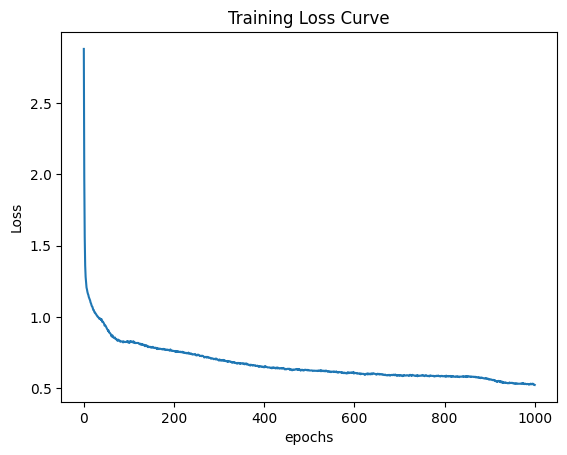

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [31]:
%load_ext tensorboard

%tensorboard --logdir=logs//SplitFSSLMaxpool_resnet18 --bind_all --port=7055

Reusing TensorBoard on port 7055 (pid 122596), started 1 day, 1:16:50 ago. (Use '!kill 122596' to kill it.)

## Fine-tune

In [32]:
import os
import argparse
import pickle
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import SequentialSampler
from torchvision import datasets, models, transforms

In [33]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [34]:
def distribute_noniid_testdata_label(labels, num_users, noniid_ratio = 0.55, num_class = 10):
    allnum = len(labels)
    num_imgs_per_client = int(allnum / num_users / num_class)
    
    noniid_ratio_other = float(0.45/9)
    targets = np.array(labels)
    targetsid = set(range(allnum))
    testdict = {i: [] for i in range(num_users)}
    classesdict = {i: [] for i in range(num_class)}
    for y in range(num_class):  
        idx = np.where(targets == y)[0]
        classesdict[i].extend(idx)
        for i in range(num_users):
            if (i%10) == y:
                temp = np.random.choice(idx, int(num_imgs_per_client*noniid_ratio), replace=False)
            else:
                temp = np.random.choice(idx, int(num_imgs_per_client*noniid_ratio_other), replace=False)
            
            # print(f"class {y} client {i} train: {len(tidx)} fin: {len(fidx)}")
            # finedict[i] = np.concatenate((finedict[i], fidx), axis=0)
            # traindict[i] = np.concatenate((traindict[i], tidx), axis=0)
            testdict[i].extend(temp)
            idx = np.setdiff1d(idx, temp)
            
    for i in range(num_users):
        testdict[i] = np.array(testdict[i], dtype=object).flatten()

    return testdict, classesdict

In [35]:
def noniid_testdata_label(labels, num_users, noniid_ratio = 0.2, num_class = 10):
    num_class_per_client = int(noniid_ratio * num_class)
    
    num_shards, num_imgs = num_class_per_client * num_users, int(len(labels)/num_users/num_class_per_client)

    idx_shard = np.array([i for i in range(num_shards)])
    idx_shard = idx_shard % num_class
    dict_users_labeled = {i: [] for i in range(num_users)}
    dict_classes_labeled = {i: [] for i in range(num_class)}
    labels_np = np.array(labels)
    for i in range(num_users):
        rand_set = idx_shard[i*num_class_per_client:(i+1)*num_class_per_client]
        for rand in rand_set:
            idx = np.where(labels_np == rand)[0]
            idx = np.random.choice(idx, num_imgs, replace=False)
            dict_users_labeled[i].extend(idx)
        dict_users_labeled[i] = set(np.array(dict_users_labeled[i]))
    
    for i in range(num_class):                                           
        idx = np.where(labels_np == i)[0]
        dict_classes_labeled[i].extend(idx)
        dict_classes_labeled[i] = set(np.array(dict_classes_labeled[i]))

    return dict_users_labeled, dict_classes_labeled

In [36]:
def inference(loader, model, device):
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)

        # get encoding
        with torch.no_grad():
            h = model(x)

        h = h.squeeze()
        h = h.detach()

        feature_vector.extend(h.cpu().detach().numpy())
        labels_vector.extend(y.numpy())

        if step % 5 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector

def get_features(model, train_loader, test_loader, device):
    train_X, train_y = inference(train_loader, model, device)
    test_X, test_y = inference(test_loader, model, device)
    return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, test_y_dict, classes_dict, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    # Fine tuning by all CIFAR10 training data
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )
    
    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    testing_loader_list = []
    training_loader_list = []
    testing_classloader_list = []
    # Fine tuning by split CIFAR10 training data
    # for i in range(len(train_dict)):
    #     training_subset = DatasetSplit(train, train_dict[i])
    #     train_loader = torch.utils.data.DataLoader(
    #         training_subset, batch_size=batch_size, shuffle=False
    #     )
    #     training_loader_list.append(train_loader)
    for i in range(len(test_y_dict)):
        testing_subset = DatasetSplit(test, test_y_dict[i])
        test_loader = torch.utils.data.DataLoader(
            testing_subset, batch_size=batch_size, shuffle=False
        )
        testing_loader_list.append(test_loader)
    for i in range(len(classes_dict)):
        testing_subset = DatasetSplit(test, classes_dict[i])
        test_loader = torch.utils.data.DataLoader(
            testing_subset, batch_size=batch_size, shuffle=False
        )
        testing_classloader_list.append(test_loader)
        
    return train_loader, testing_loader_list, testing_classloader_list

In [37]:
train_dataset = datasets.CIFAR10(
        "./data",
        download=True,
        transform=TransformsSimCLR(size=32).test_transform,
    )

test_dataset = datasets.CIFAR10(
    "./data",
    train=False,
    download=True,
    transform=TransformsSimCLR(size=32).test_transform,
)
indices = torch.randperm(len(train_dataset))[:int(len(train_dataset)* data_portion)]
train_dataset = torch.utils.data.Subset(train_dataset, indices)

indices = torch.randperm(len(test_dataset))[:int(len(test_dataset)* data_portion)]
test_dataset = torch.utils.data.Subset(test_dataset, indices)

NameError: name 'TransformsSimCLR' is not defined

In [ ]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        drop_last=True,
        num_workers=4,
    )
    
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    drop_last=False,
    num_workers=4,
)

In [ ]:
noniid_ratio = 0.55
batch_size = 20
resnet = ResNet18(num_classes=10)
resnet.fc = MLP(resnet.feature_dim, 2048, 4096)
# resnet.load_state_dict(torch.load(f"./model/SplitFSSL_resnet18/resnet18_cifar10_noniid_{batch_size}_{noniid_ratio}_0904_final.pt", map_location=device))
# resnet.load_state_dict(torch.load(save_path + "_final.pt", map_location=device))
resnet.load_state_dict(torch.load(save_path + f"_200_epoch.pt", map_location=device))
resnet = resnet.to(device)

In [ ]:
num_features = list(resnet.children())[-1].in_features
num_features

In [ ]:
# throw away fc layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
n_classes = 10 # CIFAR-10 has 10 classes

# fine-tune model
logreg = nn.Sequential(nn.Linear(num_features, n_classes))
logreg = logreg.to(device)

In [ ]:
epochs = 200
# loss / optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=logreg.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200)

In [ ]:
print("Creating features from pre-trained model")
(train_X, train_y, test_X, test_y) = get_features(
    resnet, train_dataset, test_loader, device
)

In [ ]:
test_y_dict, classes_dict = noniid_testdata_label(test_y, client_num, noniid_ratio, num_class=10)
train_loader, test_loader, class_loader = create_data_loaders_from_arrays(
    train_X, train_y, test_X, test_y, test_y_dict, classes_dict, 2048
)

In [ ]:
# Train fine-tuned model
logreg.train()

p_bar = tqdm(range(epochs))
for epoch in range(epochs):
    # metrics = defaultdict(list)
    acctol = []
    losses = []
    for step, (h, y) in enumerate(train_loader):
        h = h.to(device)
        y = y.to(device)

        outputs = logreg(h)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acctol.append(accuracy)
        losses.append(loss.item())
        # metrics["Loss/train"].append(loss.item())
        # metrics["Accuracy/train"].append(accuracy)
    acctol = np.array(acctol)
    losses = np.array(losses)
    p_bar.set_description("Train Epoch: {epoch}/{epochs:4}.Loss: {loss:.4f}.Accuracy: {acc:.4f}.".format(
            epoch=epoch,
            epochs=epochs,
            loss=losses.mean(),
            acc=acctol.mean()))
    p_bar.update()
    # print(f"Epoch [{epoch}/{epochs}]: " + "\t".join([f"{k}: {np.array(v).mean()}" for k, v in metrics.items()]))
p_bar.close()


In [ ]:
 # Test fine-tuned model
logreg.eval()
acctol = []
for idx in range(len(test_loader)):
    print("### Calculating final testing performance ###")
    metrics = defaultdict(list)
    # for idx in range(len(test_loader)):
    acc = []
    for step, (h, y) in enumerate(test_loader[idx]):
        h = h.to(device)
        y = y.to(device)

        outputs = logreg(h)

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Client {idx} : Accuracy {acc.mean()}")
    
acctol = np.array(acctol)
print(f"Final test performance(noniid_ratio : {noniid_ratio}): Accuracy  : {acctol.mean()}")
print(f"Final test performance(noniid_ratio : {noniid_ratio}): " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))

    
    


In [ ]:
logreg.eval()
label = []
predict = []
print("### Calculating classes testing performance ###")
metrics = defaultdict(list)
acctol = []
for idx in range(len(class_loader)):
    acc = []
    for step, (h, y) in enumerate(class_loader[idx]):
        h = h.to(device)
        y = y.to(device)
        

        outputs = logreg(h)
        
        predict.append(outputs.argmax(1))
        label.append(y)

        # calculate accuracy and save metrics
        accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0) * 100
        acc.append(accuracy)
        metrics["Accuracy/test"].append(accuracy)
    acc = np.array(acc)
    acctol.append(acc.mean())
    print(f"Class {idx} : Accuracy {acc.mean()}")
acctol = np.array(acctol)
print(f"Final test performance: " + "\t".join([f"{k}: {acctol.mean()}" for k, v in metrics.items()]))
print(f"Final test performance: " + "\t".join([f"Fairness: {acctol.std()}" for k, v in metrics.items()]))


In [ ]:
test_dataset = datasets.CIFAR10(
    "./data",
    train=False,
    download=True,
    transform=TransformsSimCLR(size=64).test_transform,
)

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(10, 4))
label_id = np.array(test_dataset.targets)
idx = np.where(label_id == i)[0]
for i in range(10):
    idx = np.where(label_id == i)[0]
    tensor_data = test_dataset[idx[3]][0]
    tensor_to_pil = transforms.ToPILImage()
    pil_image = tensor_to_pil(tensor_data)
    axes[i].imshow(pil_image, cmap='gray')
    axes[i].set_title(test_dataset[idx[0]][1])    


# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖形
plt.show()

In [ ]:
import seaborn 